##### Copyright 2019 The TensorFlow Authors.

In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Predicción de series temporales

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver código fuente en GitHub</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar bloc de notas</a>
</td>
</table>

Este tutorial es una introducción a la predicción de series temporales usando TensorFlow. Construye algunos estilos diferentes de modelos, incluyendo redes neuronales convolucionales y recurrentes (CNNs y RNNs).

Se trata en dos partes principales, con subsecciones:

- Predicción para un único paso de tiempo:
    - Una sola característica.
    - Todas las características.
- Predicción de múltiples pasos:
    - De una sola vez: Realice todas las predicciones a la vez.
    - Autorregresivo: Realiza una predicción cada vez y retroalimenta el modelo con el resultado.

## Preparación

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## El conjunto de datos meteorológicos

Este tutorial utiliza un <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">conjunto de datos de series temporales meteorológicas</a> registrados por el <a href="https://www.bgc-jena.mpg.de" class="external">Instituto Max Planck de Biogeoquímica</a>.

Este conjunto de datos contiene 14 características diferentes, como la temperatura del aire, la presión atmosférica y la humedad. Se recopilaron cada 10 minutos, a partir de 2003. Para mayor eficacia, sólo se usarán los datos recopilados entre 2009 y 2016. Esta sección del conjunto de datos fue preparada por François Chollet para su libro <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Aprendizaje Profundo con Python</a>.

In [6]:
# Download and extract the dataset
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Este tutorial sólo se ocupará de las predicciones **horarias**, así que empiece por submuestrear los datos de intervalos de 10 minutos a intervalos de una hora:

In [7]:
# Show what files are in the extracted directory
extracted_dir = os.path.dirname(zip_path)
print("Extracted to:", extracted_dir)
print("Contents:")
print(os.listdir(extracted_dir))

Extracted to: /root/.keras/datasets
Contents:
['jena_climate_2009_2016.csv.zip', 'jena_climate_2009_2016_extracted']


In [8]:
extracted_folder = os.path.join(os.path.dirname(zip_path), 'jena_climate_2009_2016_extracted')
print(os.listdir(extracted_folder))

['jena_climate_2009_2016.csv']


In [9]:
# Get the path to the extracted CSV file
csv_path = os.path.join(extracted_folder, 'jena_climate_2009_2016.csv')

In [10]:
# Load the data and slice it
df = pd.read_csv(csv_path)

# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

# Parse the 'Date Time' column
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Miremos los datos. Aquí están las primeras filas:

In [11]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


He aquí la evolución de algunas características a lo largo del tiempo:

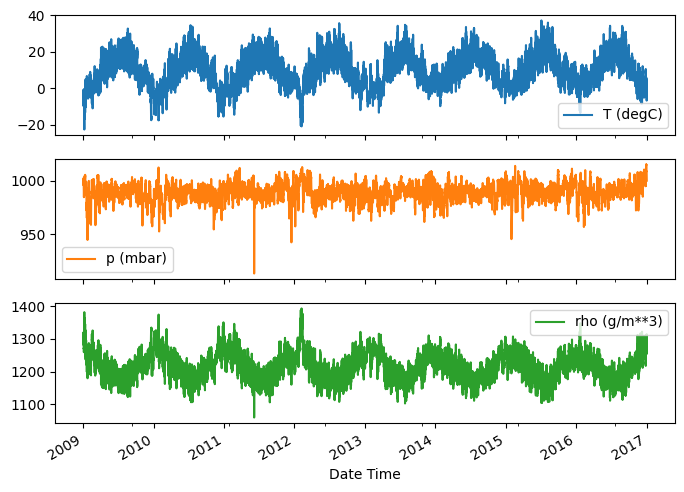

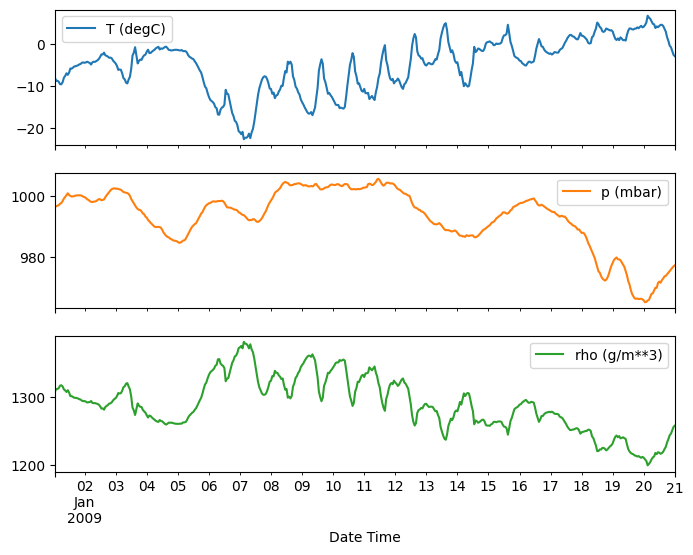

In [12]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspeccionar y despejar

Luego, observe las estadísticas del conjunto de datos:

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Velocidad del viento

Algo que debería destacar son las columnas `min` del valor de la velocidad del viento (`wv (m/s)`) y el valor máximo (`max. wv (m/s)`). Este `-9999` es probablemente erróneo.

Existe por separado una columna de dirección del viento, por lo que la velocidad debería ser mayor que cero (`>=0`). Reemplácela con ceros:

In [14]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Ingeniería de características

Antes de meternos de lleno en la construcción de un modelo, debemos entender nuestros datos y asegurarnos de que le estamos pasando al modelo datos con el formato adecuado.

#### Viento

La última columna de los datos, `wd (deg)`, da la dirección del viento en grados. Los ángulos no son un buen tipo de dato para el modelo: 360° y 0° deberían ser próximos entre sí y poder transicionar entre sí sin problemas. La dirección no debería importar si el viento no sopla.

En estos momentos, la distribución de los datos sobre el viento tiene este aspecto:

Text(0, 0.5, 'Wind Velocity [m/s]')

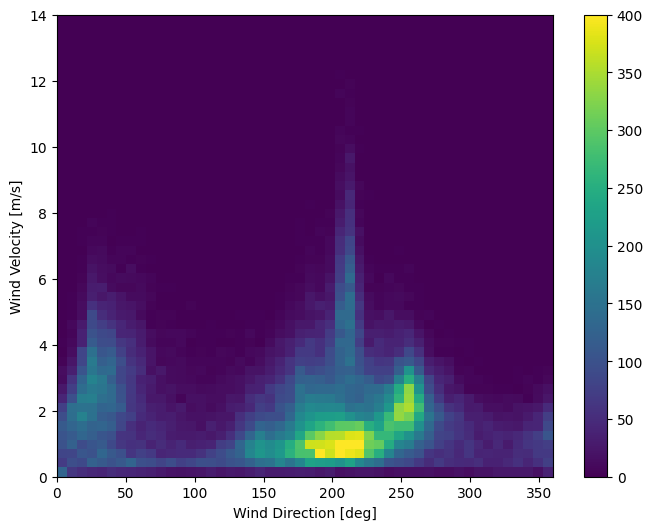

In [15]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Pero esto será más fácil de interpretar para el modelo si convierte las columnas de dirección y velocidad del viento en un **vector** de viento:

In [16]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

La distribución de los vectores de viento es mucho más sencilla de interpretar correctamente por el modelo:

(np.float64(-11.305513973134667),
 np.float64(8.24469928549079),
 np.float64(-8.27438540335515),
 np.float64(7.7338312955467785))

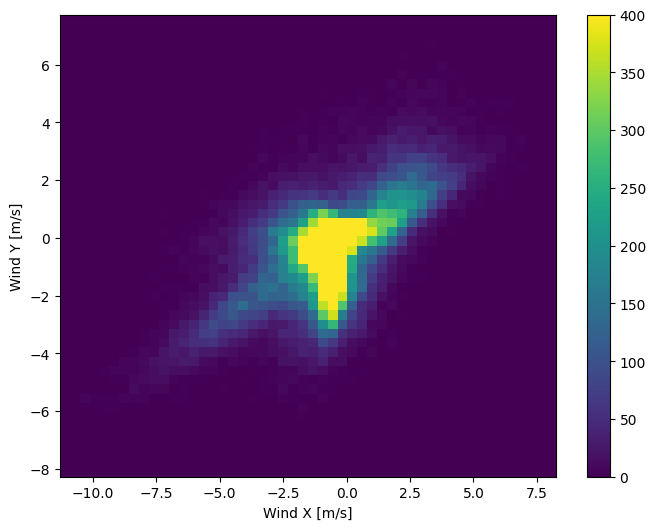

In [17]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Hora

Del mismo modo, la columna `Date Time` es muy útil, pero no en esta forma de cadena. Empiece por convertirla a segundos:

In [18]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Al igual que la dirección del viento, la hora en segundos no es un dato de entrada útil para el modelo. Al ser datos meteorológicos, tiene una clara periodicidad diaria y anual. Hay muchas formas de tratar la periodicidad.

Puede obtener señales utilizables al usar transformadas de seno y coseno para despejar las señales de "Hora del día" y "Hora del año":

In [19]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

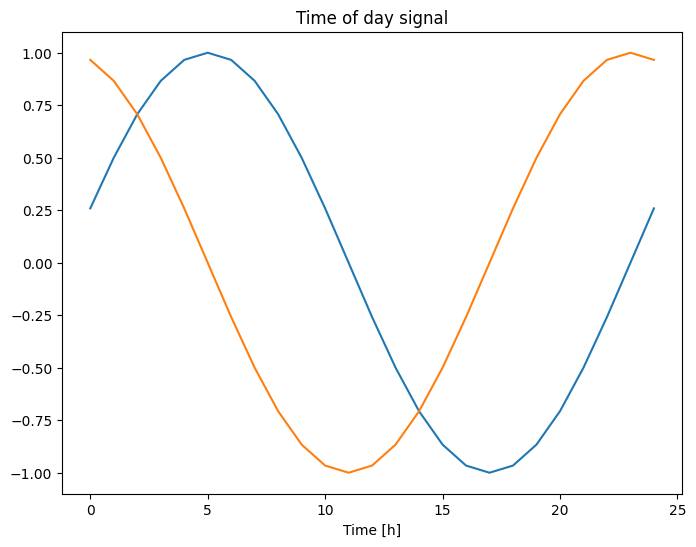

In [20]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Esto permite al modelo acceder a las frecuencias más importantes. En este caso, usted sabía de antemano qué frecuencias eran importantes.

Si no dispone de esa información, puede determinar qué frecuencias son importantes extrayendo las características con <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Transformada rápida de Fourier</a>. Para comprobar las premisas, aquí tiene el `tf.signal.rfft` de la temperatura a lo largo del tiempo. Observe los picos obvios en las frecuencias cercanas a `1/año` y `1/día`:


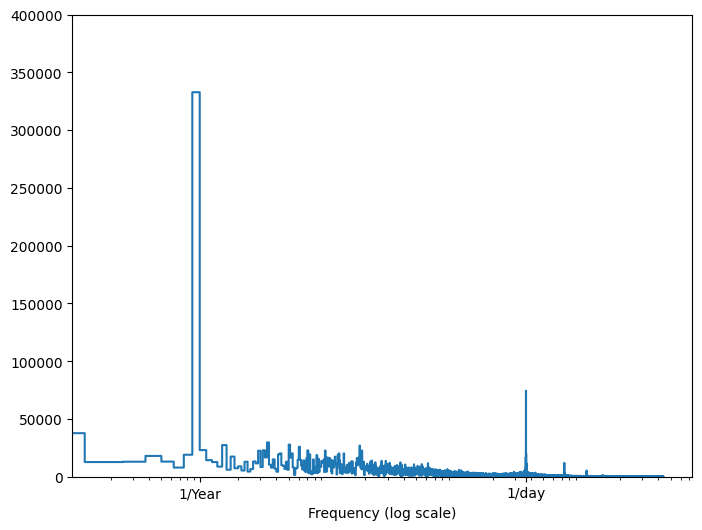

In [21]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Dividir los datos

Usará una subdivisión `(70%, 20%, 10%)` para los conjuntos de entrenamiento, validación y prueba. Observe que los datos **no** se barajan aleatoriamente antes de la subdivisión. Esto es por dos motivos:

1. Garantiza que el troceado de los datos en ventanas de muestreos consecutivos siga siendo posible.
2. Garantiza que los resultados de la validación/prueba sean más realistas, al evaluarse sobre los datos recopilados después del entrenamiento del modelo.

In [22]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalizar los datos

Es importante escalar las características antes de entrenar una red neuronal. La normalización es una forma habitual de realizar este escalado: resta la media y divide por las desviaciones estándares de cada característica.

La media y la desviación estándar sólo deben calcularse usando los datos de entrenamiento para que los modelos no tengan acceso a los valores de los conjuntos de validación y prueba.

También puede argumentarse que el modelo no debería tener acceso a los valores futuros del conjunto de entrenamiento cuando se está entrenando, y que esta normalización debería usarse usando promedios móviles. Ese no es el enfoque de este tutorial, y los conjuntos de validación y prueba garantizan que se obtengan métricas (algo) honestas. Así que, en aras de la simplicidad, este tutorial usa un promedio simple.

In [23]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Ahora, observe la distribución de las características. Algunas características tienen colas largas, pero no hay errores obvios como el valor `-9999` de la velocidad del viento.

<ipython-input-24-4ec9be458a7e>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


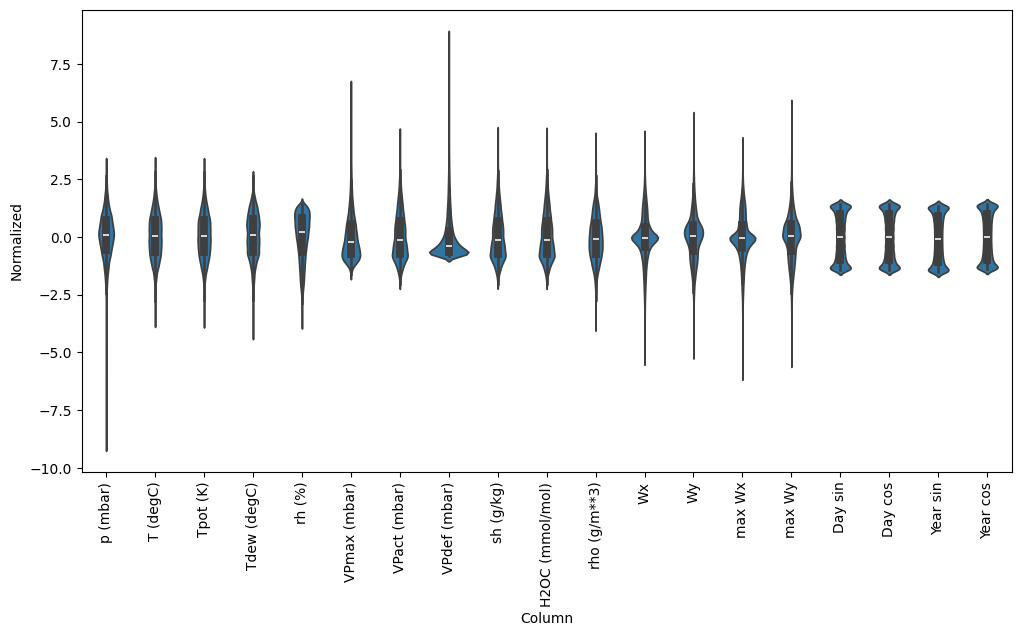

In [24]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Generar ventanas de datos

Los modelos de este tutorial configurarán un conjunto de predicciones basadas en una ventana de muestreos consecutivos de los datos.

Las principales características de las ventanas de entrada son:

- La anchura (número de pasos de tiempo) de las ventanas de entrada y de etiqueta.
- La compensación horaria entre ellos.
- Qué características se usan como entradas, etiquetas o ambas.

Este tutorial construye una variedad de modelos (incluyendo modelos lineales, DNN, CNN y RNN), y los usa en ambos casos:

- *Predicciones de salida única*, y *de salida múltiple*.
- Predicciones *de un solo paso y un solo tiempo* y *paso de varios tiempos*.

Esta sección se centra en implementar la ventana de datos para que pueda reutilizarse en todos esos modelos.


Según la tarea y el tipo de modelo, es posible que desee generar una variedad de ventanas de datos. He aquí algunos ejemplos:

1. Por ejemplo, para hacer una única predicción 24 horas en el futuro, dadas 24 horas de historia, podría definir una ventana como ésta:

![Una predicción 24 horas en el futuro.](images/raw_window_24h.png)

1. Un modelo que haga una predicción una hora en el futuro, dadas seis horas de historia, necesitaría una ventana como ésta:

![Una predicción una hora en el futuro.](images/raw_window_1h.png)

El resto de esta sección define una clase `WindowGenerator`. Esta clase puede:

1. Maneje los índices y las compensaciones como se muestra en los diagramas anteriores.
2. Divida las ventanas de características en pares `(características, etiquetas)`.
3. Trace el contenido de las ventanas resultantes.
4. Genere eficazmente lotes de estas ventanas a partir de los datos de entrenamiento, evaluación y prueba, usando `tf.data.Dataset`s.

### 1. Índices y compensaciones

Comience creando la clase `WindowGenerator`. El método `__init__` incluye toda la lógica necesaria para los índices de entrada y etiqueta.

También toma como entrada los DataFrames de entrenamiento, evaluación y prueba. Estos se convertirán en `tf.data.Dataset`s de ventanas más tarde.

In [25]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Aquí está el código para crear las 2 ventanas mostradas en los diagramas al principio de esta sección:

In [26]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [27]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. División

Dada una lista de entradas consecutivas, el método `split_window` las convertirá en una ventana de entradas y una ventana de etiquetas.

El ejemplo `w2` que definió anteriormente se dividirá así:

![La ventana inicial son todos los muestreos consecutivos, esto la divide en pares (entradas, etiquetas)](images/split_window.png)

Este diagrama no muestra el eje `features` de los datos, pero esta función `split_window` también gestiona las `label_columns`, por lo que puede usarse tanto para los ejemplos de salida única como para los de salida múltiple.

In [28]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Haga la prueba:

In [29]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


Típicamente, los datos en TensorFlow se empaquetan en arreglos donde el índice más externo recorre los ejemplos (la dimensión "lote"). Los índices intermedios son la(s) dimensión(es) "tiempo" o "espacio" (anchura, altura). Los índices más internos son las características.

El código anterior toma un lote de tres ventanas de 7 pasos de tiempo con 19 características en cada uno. Las divide en un lote de entradas de 6 pasos de tiempo con 19 características y una etiqueta de 1 paso de tiempo con 1 característica. La etiqueta sólo tiene una característica porque el `WindowGenerator` se inicializó con `label_columns=['T (degC)']`. Inicialmente, este tutorial construirá modelos que predicen etiquetas de salida únicas.

### 3. Graficar

He aquí un método de graficado que permite una visualización sencilla de la ventana dividida:

In [30]:
w2.example = example_inputs, example_labels

In [31]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Este gráfico alinea las entradas, las etiquetas y las predicciones (posteriores) en función del tiempo al que se refiere el artículo:

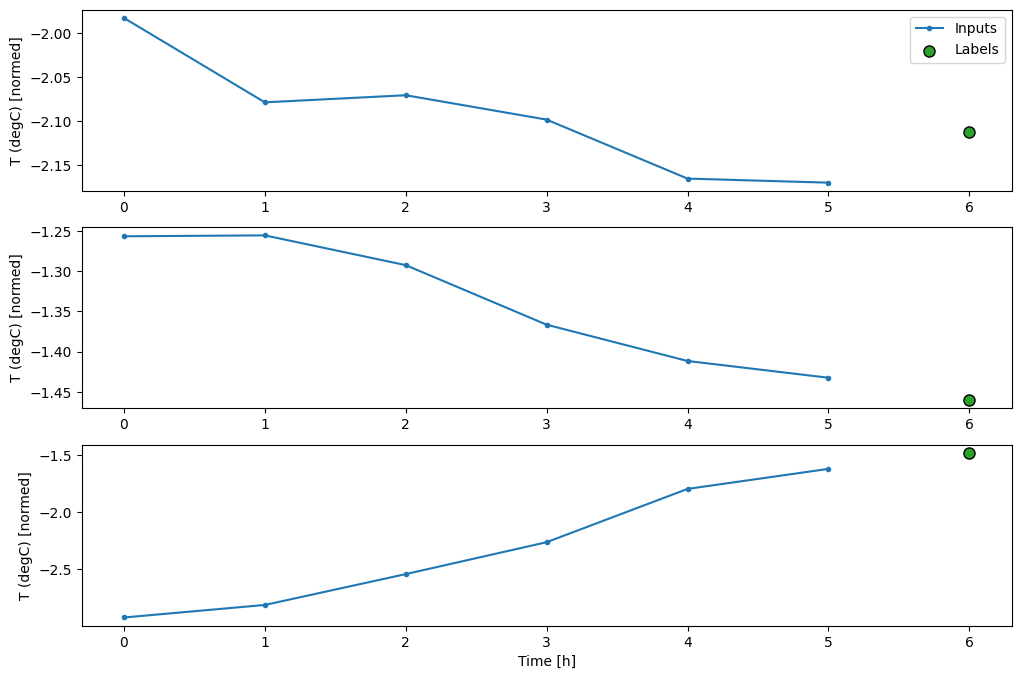

In [32]:
w2.plot()

Puede graficar las otras columnas, pero la configuración de la ventana de ejemplo `w2` sólo tiene etiquetas para la columna `T (degC)`.

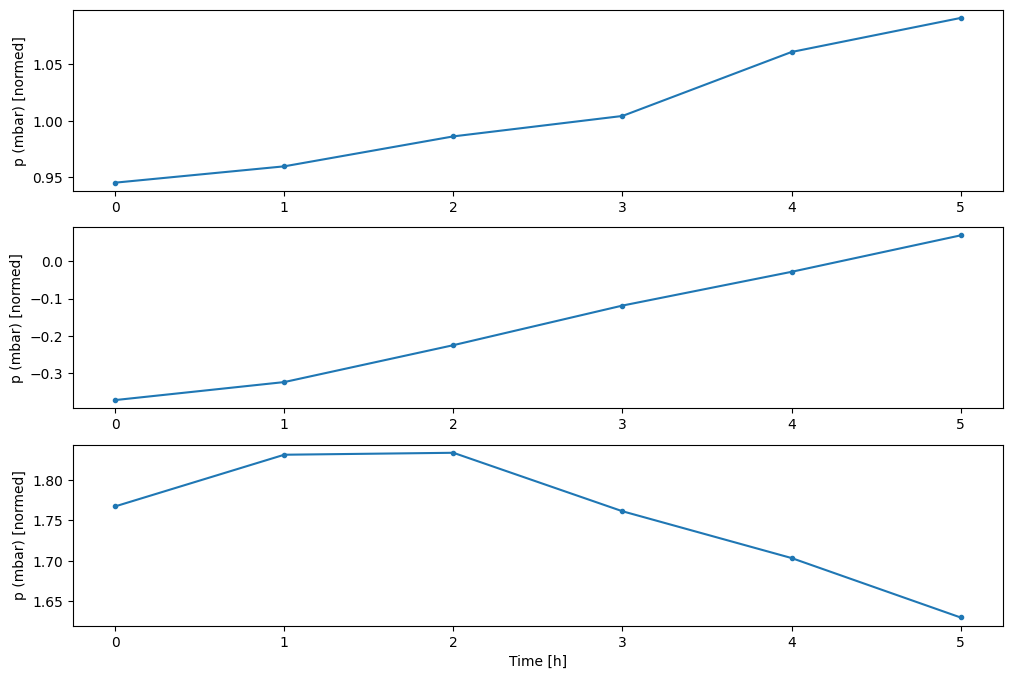

In [33]:
w2.plot(plot_col='p (mbar)')

### 4. Crear `tf.data.Dataset`s

Por último, este método `make_dataset` tomará un DataFrame de series temporales y lo convertirá en un `tf.data.Dataset` de pares `(input_window, label_window)` utilizando la función `tf.keras.utils.timeseries_dataset_from_array`:

In [34]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

El objeto `WindowGenerator` contiene los datos de entrenamiento, validación y prueba.

Añada propiedades para accesarlas como `tf.data.Dataset`s usando el método `make_dataset` que definió anteriormente. Añada también un lote de ejemplo estándar para facilitar el acceso y la graficación:

In [35]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Ahora, el objeto `WindowGenerator` le da acceso a los objetos `tf.data.Dataset`, por lo que puede iterar fácilmente sobre los datos.

La propiedad `Dataset.element_spec` le indica la estructura, los tipos de datos y las formas de los elementos del conjunto de datos.

In [36]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Al iterar sobre un `Dataset` se obtienen lotes concretos:

In [37]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Modelos de un solo paso

El modelo más sencillo que se puede construir con este tipo de datos es el que predice el valor de una sola característica en 1 paso de tiempo (una hora) en el futuro basándose únicamente en las condiciones actuales.

Así pues, empiece construyendo modelos para predecir el valor de `T (degC)` una hora en el futuro.

![Predecir el siguiente paso de tiempo](images/narrow_window.png)

Configure un objeto `WindowGenerator` para producir estos pares `(input,label)` en un solo paso:

In [38]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

El objeto `window` crea `tf.data.Dataset`s a partir de los conjuntos de entrenamiento, validación y prueba, lo que le permite iterar fácilmente sobre lotes de datos.


In [39]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Linea de referencia

Antes de construir un modelo entrenable sería bueno tener una línea de referencia de rendimiento como punto de comparación con los modelos posteriores más complicados.

Esta primera tarea consiste en predecir la temperatura una hora en el futuro, dado el valor actual de todas las características. Los valores actuales incluyen la temperatura actual.

Así pues, empiece con un modelo que sólo devuelva la temperatura actual como predicción, pronosticando "Sin cambios". Se trata de una línea de referencia razonable, ya que la temperatura cambia lentamente. Por supuesto, esta línea de referencia funcionará peor si hace una predicción más lejana en el futuro.

![Enviar la entrada a la salida](images/baseline.png)

In [40]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instanciar y evaluar este modelo:

In [41]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0129 - mean_absolute_error: 0.0783


Eso imprimió algunas métricas de rendimiento, pero no le dan una idea de lo bien que va el modelo.

El `WindowGenerator` tiene un método de graficación, pero los gráficos no serán muy interesantes con un solo muestreo.

Por tanto, cree un `WindowGenerator` más amplio que genere ventanas de 24 horas de entradas y etiquetas consecutivas a la vez. La nueva variable `wide_window` no cambia el funcionamiento del modelo. El modelo sigue haciendo predicciones una hora en el futuro basándose en un único paso de tiempo de entrada. Aquí, el eje `time` actúa como el eje `batch`: cada predicción se realiza de forma independiente sin interacción entre los pasos de tiempo:

In [42]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

Esta ventana ampliada puede pasarse directamente al mismo modelo `baseline` sin ningún cambio de código. Esto es posible porque las entradas y las etiquetas tienen el mismo número de pasos de tiempo, y la línea de referencia sólo reenvía la entrada a la salida:

![Una predicción 1 hora en el futuro, cada hora.](images/last_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Al graficar las predicciones del modelo base, observe que se trata simplemente de las etiquetas desplazadas una hora hacia la derecha:

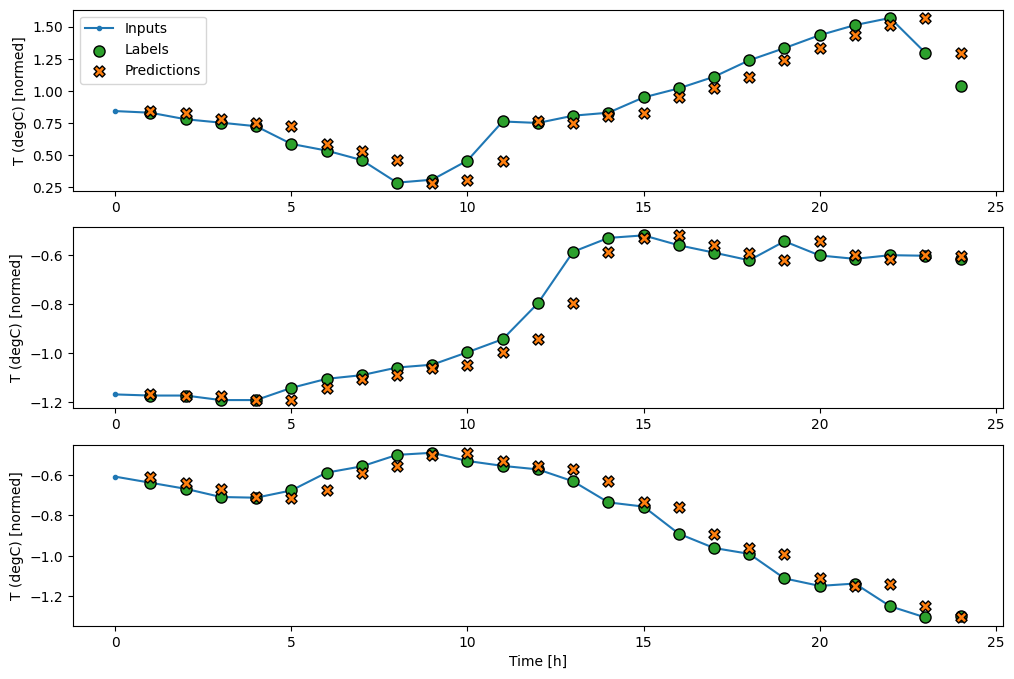

In [44]:
wide_window.plot(baseline)

En los gráficos anteriores de tres ejemplos, el modelo de un solo paso se ejecuta en el transcurso de 24 horas. Esto merece una explicación:

- La línea azul `Inputs` muestra la temperatura de entrada en cada paso de tiempo. El modelo recibe todas las características, este gráfico sólo muestra la temperatura.
- Los puntos verdes `Labels` muestran el valor de predicción objetivo. Estos puntos se muestran en el momento de la predicción, no en el momento de la entrada. Por eso el rango de etiquetas está desplazado 1 paso con respecto a las entradas.
- Las cruces naranjas `Predictions` son las predicciones del modelo para cada paso de tiempo de salida. Si el modelo predijera a la perfección, las predicciones caerían directamente sobre las `Labels`.

### Modelo lineal

El modelo **entrenable** más sencillo que puede aplicar a esta tarea es insertar una transformación lineal entre la entrada y la salida. En este caso, la salida de un paso temporal sólo depende de ese paso:

![Una predicción en un solo paso](images/narrow_window.png)

Una capa `tf.keras.layers.Dense` sin un conjunto de `activation` es un modelo lineal. La capa sólo transforma el último eje de los datos de `(batch, time, inputs)` a `(batch, time, units)`; se aplica independientemente a cada artículo a través de los ejes `batch` y `time`.

In [45]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [46]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


Este tutorial entrena muchos modelos, así que empaquete el procedimiento de entrenamiento en una función:

In [47]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Entrene el modelo y evalúe su rendimiento:

In [48]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.6176 - mean_absolute_error: 0.8501 - val_loss: 0.0266 - val_mean_absolute_error: 0.1223
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0250 - mean_absolute_error: 0.1162 - val_loss: 0.0119 - val_mean_absolute_error: 0.0817
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0121 - mean_absolute_error: 0.0813 - val_loss: 0.0094 - val_mean_absolute_error: 0.0715
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0096 - mean_absolute_error: 0.0721 - val_loss: 0.0089 - val_mean_absolute_error: 0.0695
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0094 - mean_absolute_error: 0.0713 - val_loss: 0.0090 - val_mean_absolute_error: 0.0698
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0094 - mean_absolute_error: 0.0710 - val_loss: 0.0088 - val_mean_absolute_error: 0.0692
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0093 - mean_absolute_

Al igual que el modelo `baseline`, el modelo lineal puede invocarse en lotes de ventanas amplias. Usado de esta manera, el modelo configura un conjunto de predicciones independientes en pasos de tiempo consecutivos. El eje `time` actúa como otro eje `batch`. No hay interacciones entre las predicciones en cada paso de tiempo.

![Una predicción de un solo paso](images/wide_window.png)

In [49]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Este es el gráfico de sus predicciones de ejemplo en la `wide_window`, observe cómo en muchos casos la predicción es claramente mejor que devolver simplemente la temperatura de entrada, pero en unos pocos casos es peor:

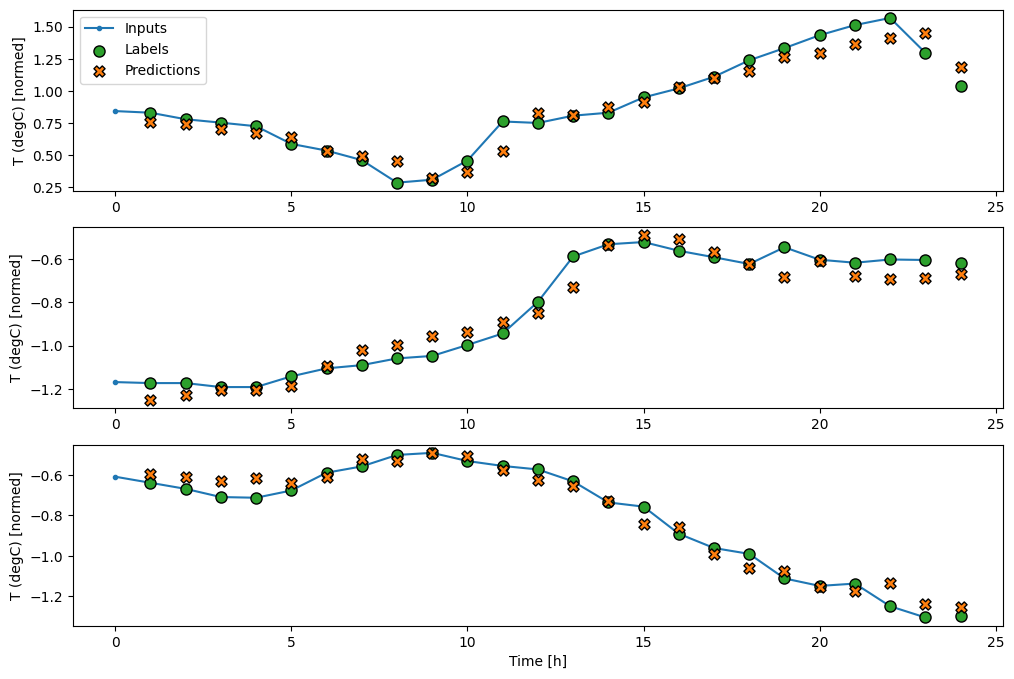

In [50]:
wide_window.plot(linear)

Una ventaja de los modelos lineales es que son relativamente sencillos de interpretar. Puede extraer las ponderaciones de las capas y visualizar la ponderación asignada a cada entrada:

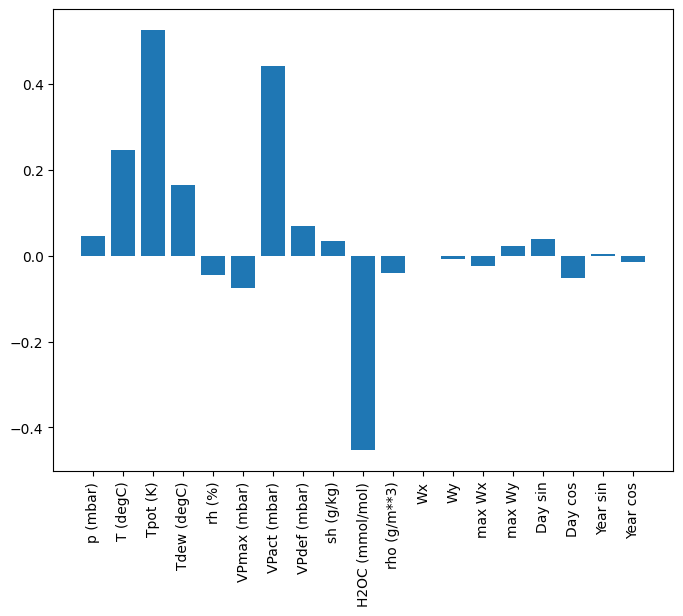

In [51]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

A veces, el modelo ni siquiera pone la mayor ponderación en la entrada `T (degC)`. Este es uno de los riesgos de la inicialización aleatoria.

### Dense

Antes de aplicar modelos que operen realmente en múltiples pasos de tiempo, vale la pena comprobar el rendimiento de modelos más profundos y potentes de un solo paso de entrada.

Éste es un modelo similar al `linear`, salvo que apila varias capas `Dense` entre la entrada y la salida:

In [52]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0318 - mean_absolute_error: 0.1046 - val_loss: 0.0077 - val_mean_absolute_error: 0.0629
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0078 - mean_absolute_error: 0.0640 - val_loss: 0.0073 - val_mean_absolute_error: 0.0605
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0623 - val_loss: 0.0069 - val_mean_absolute_error: 0.0582
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0070 - mean_absolute_error: 0.0597 - val_loss: 0.0073 - val_mean_absolute_error: 0.0618
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0069 - mean_absolute_error: 0.0590 - val_loss: 0.0068 - val_mean_absolute_error: 0.0579
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0068 - mean_absolute_error: 0.0582 - val_loss: 0.0068 - val_mean_absolute_error: 0.0574
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0067 - mean_absolu

### Dense multipaso

Un modelo de un solo paso de tiempo no tiene contexto para los valores actuales de sus entradas. No puede ver cómo cambian las características de entrada a lo largo del tiempo. Para resolver este problema, el modelo necesita tener acceso a múltiples pasos de tiempo a la hora de hacer predicciones:

![Para cada predicción se usan tres pasos de tiempo.](images/conv_window.png)


Los modelos `baseline`, `linear` y `dense` tratan cada paso de tiempo de forma independiente. Aquí el modelo tomará múltiples pasos de tiempo como entrada para producir una única salida.

Cree un `WindowGenerator` que producirá lotes de entradas de tres horas y etiquetas de una hora:

Fíjese en que el parámetro `Window` de `shift` es relativo al final de las dos ventanas.


In [53]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

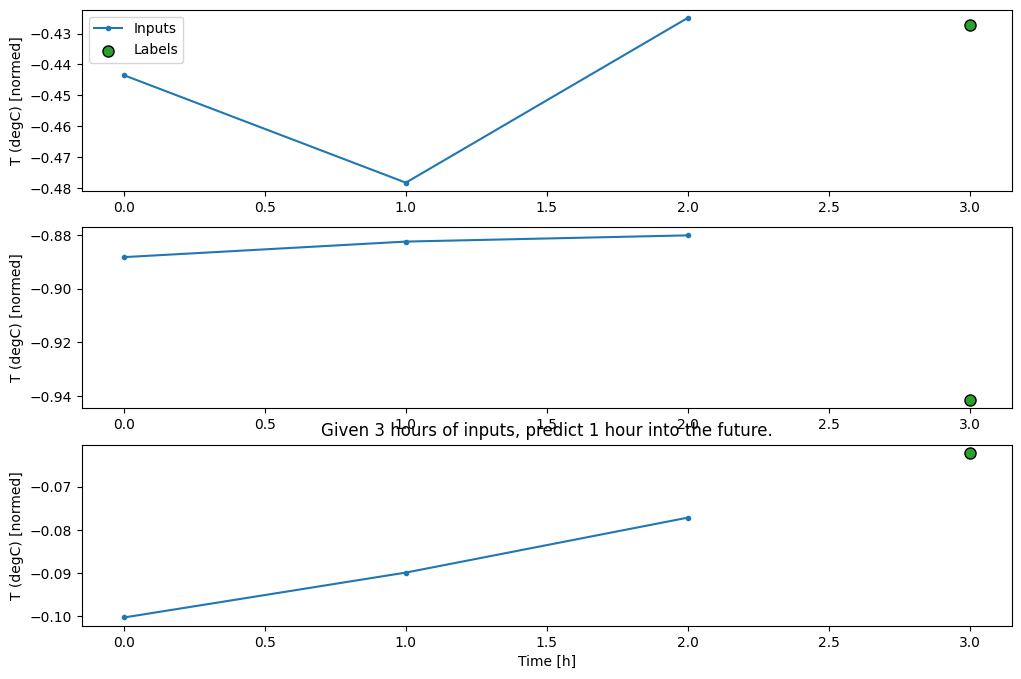

In [54]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

Puede entrenar un modelo `dense` en una ventana de múltiples pasos de entrada añadiendo un `tf.keras.layers.Flatten` como primera capa del modelo:

In [55]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [56]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [57]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0068 - mean_absolute_error: 0.0603


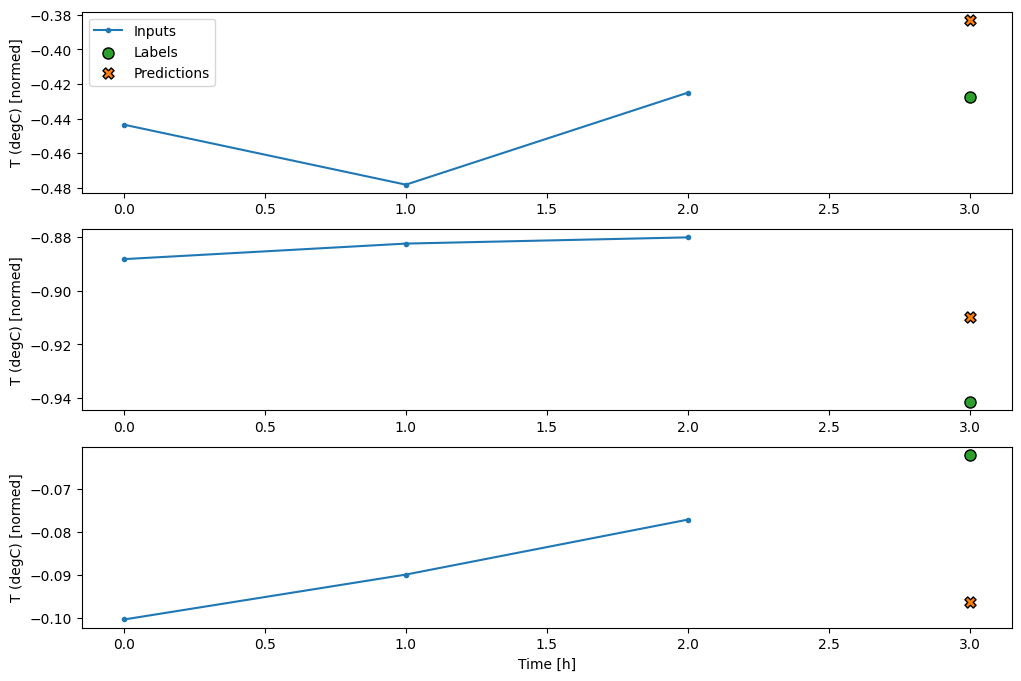

In [58]:
conv_window.plot(multi_step_dense)

El principal inconveniente de este enfoque es que el modelo resultante sólo puede ejecutarse en ventanas de entrada de exactamente esta forma.

In [59]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


Los modelos convolucionales de la siguiente sección solucionan este problema.

### Red neuronal de convolución

Una capa de convolución (`tf.keras.layers.Conv1D`) también toma múltiples pasos de tiempo como entrada para cada predicción.

A continuación se muestra el **mismo** modelo que `multi_step_dense`, reescrito con una convolución.

Observe los cambios:

- El `tf.keras.layers.Flatten` y el primer `tf.keras.layers.Dense` son sustituidos por un `tf.keras.layers.Conv1D`.
- El `tf.keras.layers.Reshape` deja de ser necesario puesto que la convolución conserva el eje temporal en su salida.

In [60]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Ejecútelo en un lote de ejemplo para verificar que el modelo produce salidas con la forma esperada:

In [61]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Entrénelo y evalúelo en el modelo `conv_window` y debería dar un rendimiento similar al modelo `multi_step_dense`.

In [62]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0066 - mean_absolute_error: 0.0579


La diferencia entre este modelo `conv_model` y el modelo `multi_step_dense` es que el modelo `conv_model` puede ejecutarse con entradas de cualquier longitud. La capa convolucional se aplica a una ventana deslizante de entradas:

![Ejecución de un modelo convolucional en una secuencia](images/wide_conv_window.png)

Si lo ejecuta en una entrada más amplia, produce una salida más amplia:

In [63]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Observe que la salida es más corta que la entrada. Para que el entrenamiento o la graficación funcionen, es necesario que las etiquetas y la predicción tengan la misma longitud. Así que construya un `WindowGenerator` para producir ventanas amplias con algunos pasos de tiempo de entrada adicionales para que las longitudes de la etiqueta y la predicción coincidan:

In [64]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [65]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Ahora, puede graficar las predicciones del modelo en una ventana más amplia. Observe los 3 pasos de tiempo de entrada antes de la primera predicción. Cada predicción aquí se basa en los 3 pasos de tiempo precedentes:

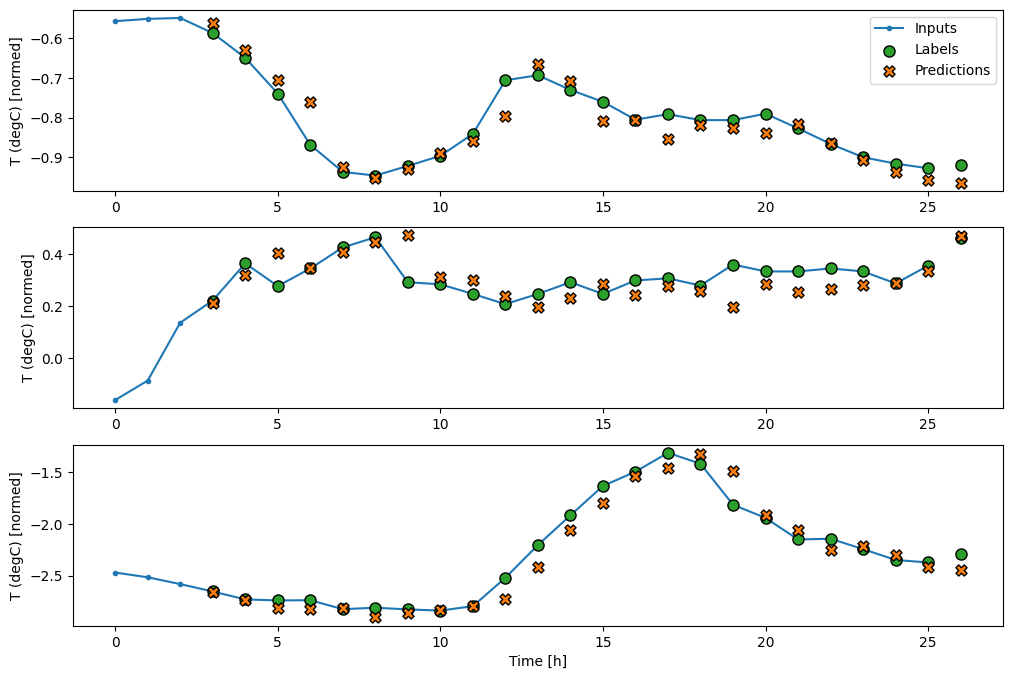

In [66]:
wide_conv_window.plot(conv_model)

### Red neuronal recurrente

Una red neuronal recurrente (RNN) es un tipo de red neuronal muy adecuada para los datos de series temporales. Las RNN procesan una serie temporal paso a paso, manteniendo un estado interno de paso de tiempo en paso de tiempo.

Puede obtener más información en el tutorial [Generación de texto con una RNN](https://www.tensorflow.org/text/tutorials/text_generation) y en la guía [Redes neuronales recurrentes (RNN) con Keras](https://www.tensorflow.org/guide/keras/rnn).

En este tutorial, usará una capa RNN llamada Memoria a corto-largo plazo (`tf.keras.layers.LSTM`).

Un argumento importante del constructor para todas las capas RNN de Keras, como `tf.keras.layers.LSTM`, es el argumento `return_sequences`. Este parámetro puede configurar la capa de dos maneras:

1. Si es `False`, el predeterminado, la capa sólo devuelve la salida del último paso de tiempo, dando tiempo al modelo para calibrar su estado interno antes de hacer una sola predicción:

![Un LSTM calibrándose y haciendo una única predicción](images/lstm_1_window.png)

1. Si es `True`, la capa devuelve una salida para cada entrada. Esto es útil para:
    - Apilar capas RNN.
    - Entrenar un modelo en múltiples pasos de tiempo simultáneamente.

![Un LSTM haciendo una predicción después de cada paso de tiempo](images/lstm_many_window.png)

In [67]:
# Define the LSTM model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

# Compile the model with the 'mean_absolute_error' metric
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Print the model summary and compiled metrics for debugging
print("Model summary:")
print(lstm_model.summary())
print("Compiled metrics:", lstm_model.metrics_names)

Model summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Compiled metrics: ['loss', 'compile_metrics']


Con `return_sequences=True`, el modelo puede entrenarse con 24 horas de datos cada vez.

Nota: Esto dará una visión pesimista del rendimiento del modelo. En el primer paso de tiempo, el modelo no tiene acceso a los pasos anteriores y, por lo tanto, no puede hacerlo mejor que los modelos simples `linear` y `dense` mostrados anteriormente.

In [68]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [69]:
# Train the model
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0056 - mean_absolute_error: 0.0509


In [70]:
# Print the evaluation results for debugging
print("Validation performance:", val_performance)
print("Test performance:", performance)

Validation performance: {'Baseline': [0.01284563634544611, 0.07846629619598389], 'Linear': [0.00871330127120018, 0.0685969889163971], 'Dense': [0.006581547670066357, 0.056821517646312714], 'Multi step dense': [0.006894717458635569, 0.06083057075738907], 'Conv': [0.006598356645554304, 0.05804472416639328], 'LSTM': [0.0055531468242406845, 0.05082166567444801]}
Test performance: {'Baseline': [0.014162614941596985, 0.08516014367341995], 'Linear': [0.008449755609035492, 0.06697630882263184], 'Dense': [0.006281994748860598, 0.05607139319181442], 'Multi step dense': [0.006612467113882303, 0.05996337905526161], 'Conv': [0.0063485498540103436, 0.05743055045604706], 'LSTM': [0.0055231056176126, 0.05195888876914978]}


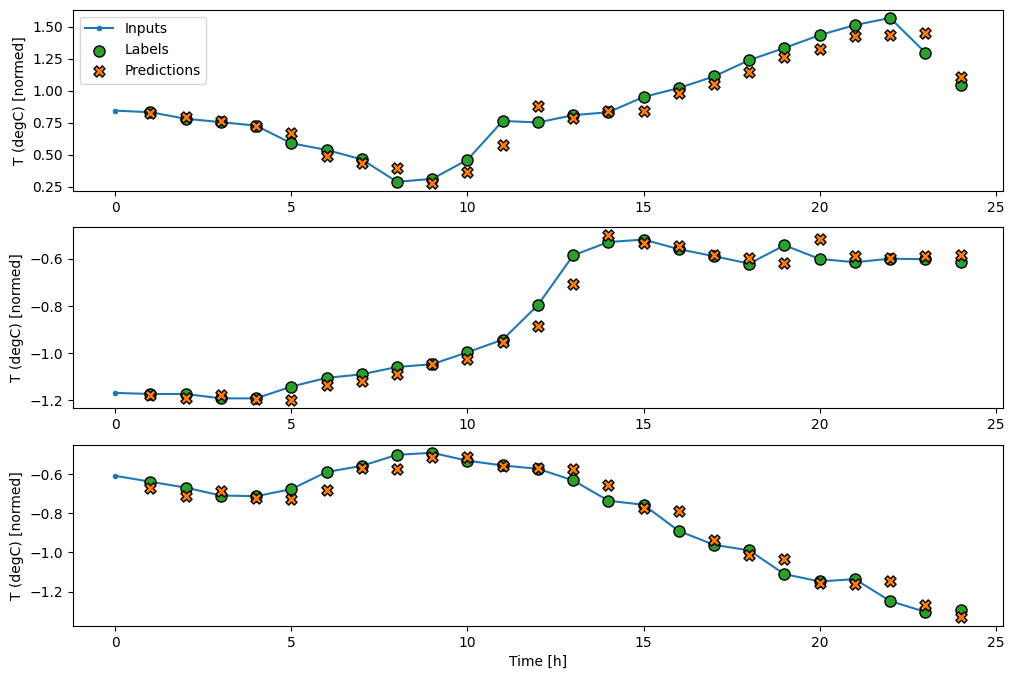

In [71]:
wide_window.plot(lstm_model)

### Rendimiento

Con este conjunto de datos, normalmente cada uno de los modelos obtiene resultados ligeramente mejores que el anterior:

In [72]:
# Plot the performance metrics
x = np.arange(1)  # Since we only have one model to compare
width = 0.3
metric_name = 'mean_absolute_error'

# Ensure the metric name is in the evaluation results
if metric_name in val_performance and metric_name in performance:
    val_mae = val_performance[metric_name]
    test_mae = performance[metric_name]

    plt.ylabel('mean_absolute_error [T (degC), normalized]')
    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=['LSTM'], rotation=45)
    plt.legend()
    plt.show()
else:
    print(f"Error: {metric_name} not found in evaluation results.")

Error: mean_absolute_error not found in evaluation results.


In [73]:
print("metrics_names:", lstm_model.metrics_names)
print("val_performance['LSTM']:", val_performance['LSTM'])


metrics_names: ['loss', 'compile_metrics']
val_performance['LSTM']: [0.0055531468242406845, 0.05082166567444801]


### Modelos multisalida

Hasta aquí, todos los modelos predijeron una única característica de salida, `T (degC)`, para un único paso de tiempo.

Todos estos modelos pueden convertirse para predecir múltiples características simplemente cambiando el número de unidades en la capa de salida y ajustando las ventanas de entrenamiento para incluir todas las características en el `labels` (`example_labels`):

In [74]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Observe arriba que el eje `features` de las etiquetas tiene ahora la misma profundidad que las entradas, en lugar de `1`.

#### Linea de referencia

Aquí se puede usar el mismo modelo de línea de referencia (`Baseline`), pero esta vez repitiendo todas las características en lugar de seleccionar una `label_index` específica:

In [75]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [76]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0887 - mean_absolute_error: 0.1591


#### Dense

In [77]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [78]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0698 - mean_absolute_error: 0.1350


#### RNN


In [79]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0611 - mean_absolute_error: 0.1199

CPU times: user 8min 48s, sys: 34.2 s, total: 9min 23s
Wall time: 7min 45s


<a id="residual"></a>

#### Advanced: Residual connections

El modelo `Baseline` utilizado anteriormente se aprovechó del hecho de que la secuencia no cambia drásticamente de un paso de tiempo a otro. Cada modelo entrenado en este tutorial hasta ahora se inicializó aleatoriamente, y luego tuvo que aprender que la salida es un pequeño cambio desde el paso de tiempo anterior.

Aunque puede evitar este problema con una inicialización cuidadosa, es más sencillo incorporarlo a la estructura del modelo.

En el análisis de series temporales es habitual construir modelos que, en lugar de predecir el valor siguiente, predicen cómo cambiará el valor en el siguiente paso de tiempo. Del mismo modo, las <a href="https://arxiv.org/abs/1512.03385" class="external">redes residuales</a> (o ResNets) en el aprendizaje profundo se refieren a arquitecturas en las que cada capa contribuye al resultado acumulativo del modelo.

Así es como se aprovecha el conocimiento de que el cambio debiera ser pequeño.

![Un modelo con una conexión residual](images/residual.png)

Esencialmente, esto inicializa el modelo para que coincida con la `Baseline`. Para esta tarea, ayuda a que los modelos converjan más rápido, con un rendimiento ligeramente mejor.

Puede usar este enfoque junto con cualquier modelo analizado en este tutorial.

Aquí, se está aplicando al modelo LSTM; nótese el uso de los `tf.initializers.zeros` para asegurar que los cambios predichos iniciales son pequeños, y no saturan la conexión residual. Aquí no hay problemas de ruptura de simetría para los gradientes, ya que los `zeros` sólo se usan en la última capa.

In [80]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [81]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

# Ensure the model is compiled with the 'mean_absolute_error' metric
residual_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0619 - mean_absolute_error: 0.1181

CPU times: user 3min 18s, sys: 13 s, total: 3min 31s
Wall time: 3min 21s


#### Rendimiento

Aquí se muestra el rendimiento global de estos modelos multisalida.

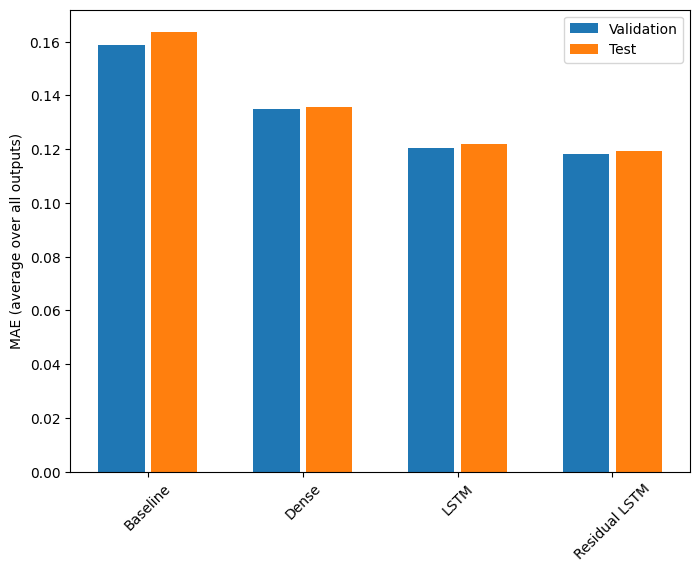

In [82]:
x = np.arange(len(performance))
width = 0.3

# Access the 'mean_absolute_error' directly from the evaluation results
val_mae = [v[1] for v in val_performance.values()] # Assuming MAE is the second metric in the evaluation results
test_mae = [v[1] for v in performance.values()]  # Assuming MAE is the second metric in the evaluation results


plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [83]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1356
LSTM           : 0.1219
Residual LSTM  : 0.1194


Los rendimientos anteriores se promedian entre todas las salidas del modelo.

## Modelos multipaso

Tanto los modelos de salida única como los de salida múltiple de las secciones anteriores hicieron **predicciones de un solo paso de tiempo**, una hora en el futuro.

En esta sección se estudia cómo ampliar estos modelos para realizar **pronósticos de múltiples pasos de tiempo**.

En una predicción multipaso, el modelo necesita aprender a predecir una serie de valores futuros. Así, a diferencia de un modelo de un solo paso, en el que sólo se predice un único punto futuro, un modelo multipaso predice una secuencia de los valores futuros.

A grandes rasgos, existen dos enfoques:

1. Predicciones en un único impulso, en las que se predice toda la serie temporal de una sola vez.
2. Predicciones autorregresivas en las que el modelo sólo realiza predicciones de un paso y su salida se realimenta como su entrada.

En esta sección, todos los modelos predecirán **todas las características a lo largo de todos los pasos de tiempo de salida**.


Para el modelo multipaso, los datos de entrenamiento vuelven a consistir en muestreos horarios. Sin embargo, aquí los modelos aprenderán a predecir 24 horas en el futuro, dadas 24 horas del pasado.

Este es un objeto `Window` que genera estos cortes a partir del conjunto de datos:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

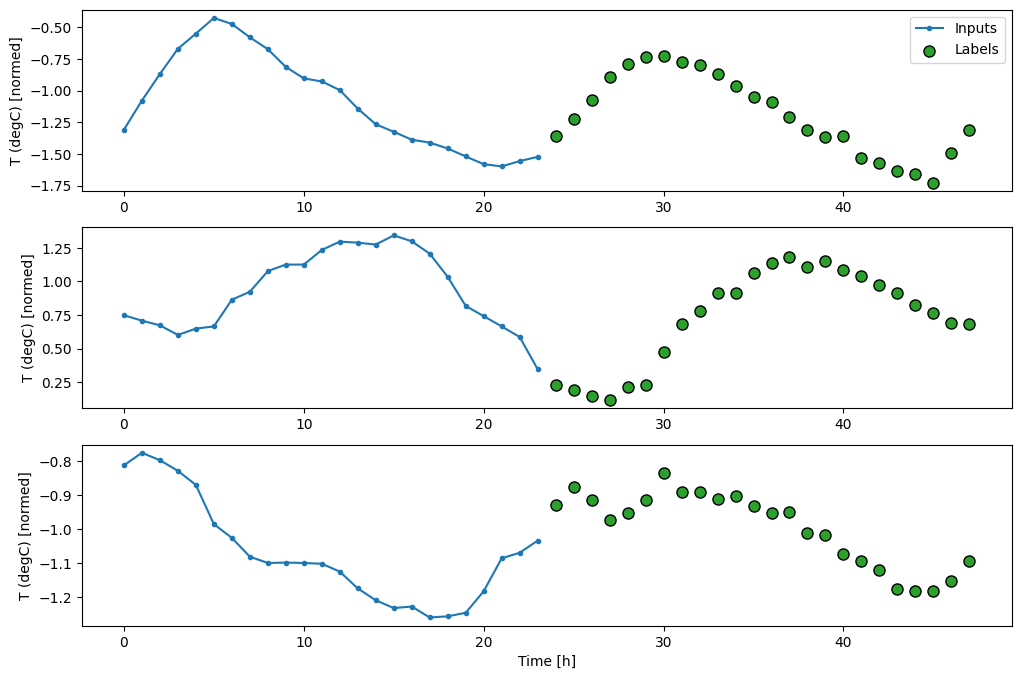

In [84]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Lineas de referencia

Una línea de referencia sencilla para esta tarea consiste en repetir el último paso de tiempo de entrada durante el número necesario de pasos de tiempo de salida:

![Repita la última entrada, para cada paso de salida](images/multistep_last.png)

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6339 - mean_absolute_error: 0.5032


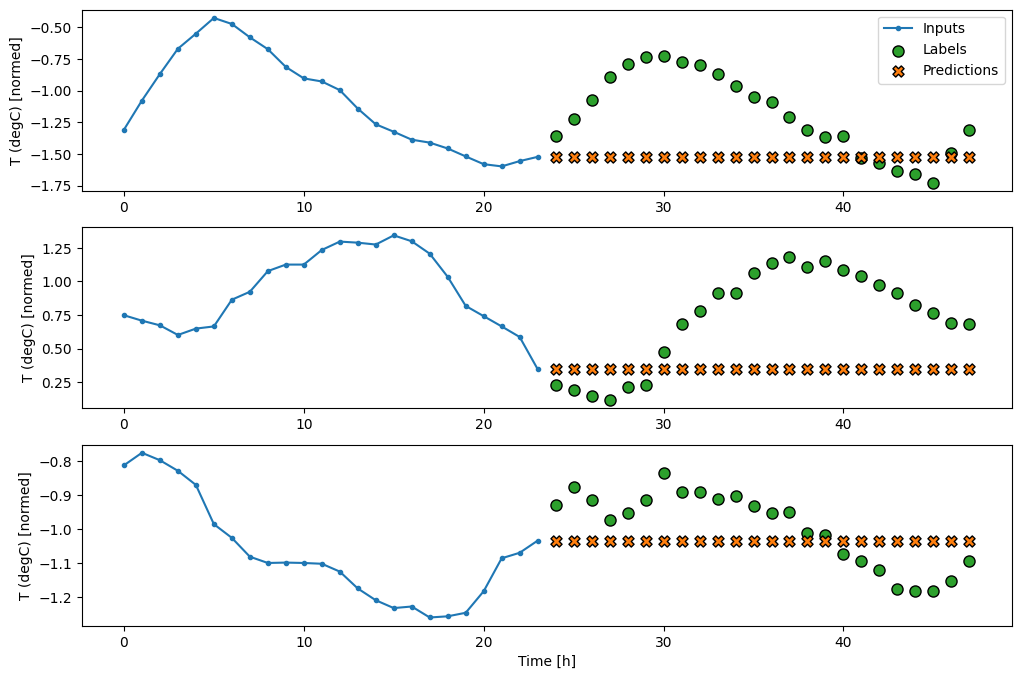

In [85]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Dado que esta tarea consiste en predecir 24 horas en el futuro, dadas 24 horas del pasado, otro enfoque sencillo es repetir el día anterior, suponiendo que mañana será similar:

![Repetir el día anterior](images/multistep_repeat.png)

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4329 - mean_absolute_error: 0.3988


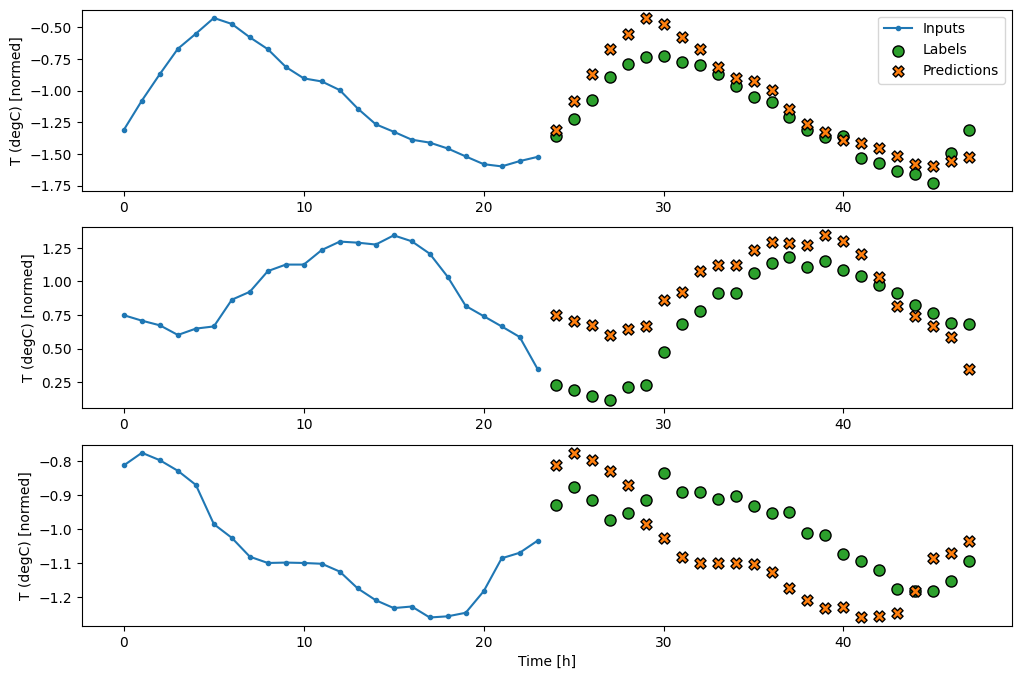

In [86]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Modelos de un solo impulso

Un enfoque de alto nivel para este problema es usar un modelo de "impulso único", en el que el modelo realiza toda la predicción de la secuencia en un solo paso.

Esto puede implementarse eficientemente como una `tf.keras.layers.Dense` con `OUT_STEPS*features` unidades de salida. El modelo sólo tiene que reestructurar esa salida a la `(OUTPUT_STEPS, features)` requerida.

#### Lineal

Un modelo lineal simple basado en el último paso de tiempo de entrada funciona mejor que cualquiera de las líneas de referencia, pero tiene poca potencia. El modelo necesita predecir `OUTPUT_STEPS` pasos de tiempo, a partir de un único paso de tiempo de entrada con una proyección lineal. Sólo puede capturar un fragmento de baja dimensión del comportamiento, probablemente basado principalmente en la hora del día y la época del año.

![Predecir todos los pasos de tiempo desde el último paso de tiempo](images/multistep_dense.png)

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2532 - mean_absolute_error: 0.3038


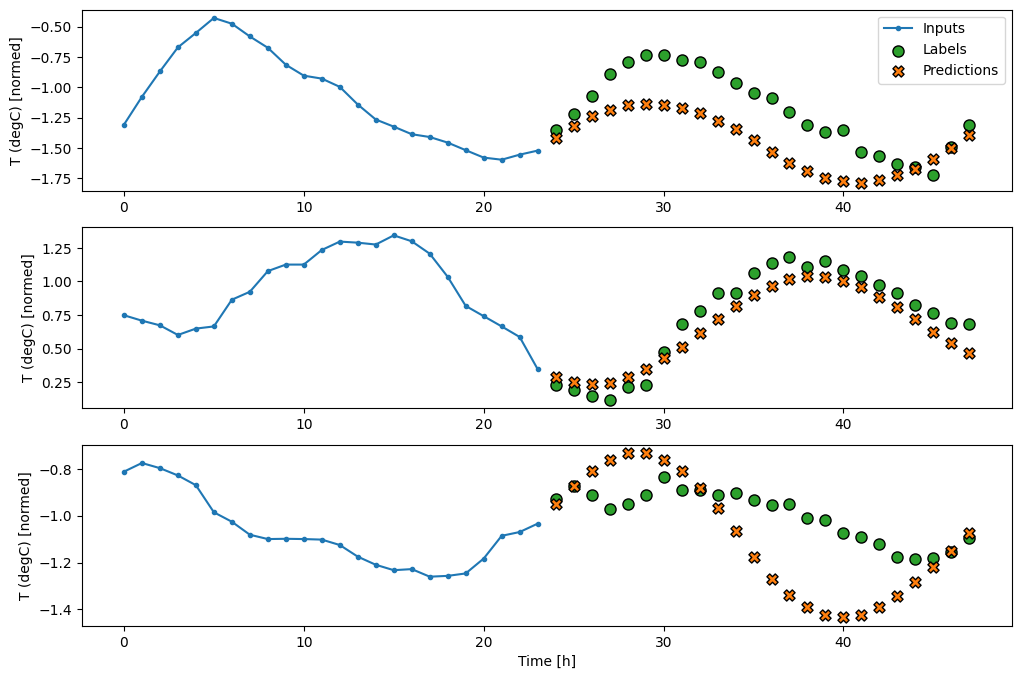

In [87]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Si se añade un `tf.keras.layers.Dense` entre la entrada y la salida, el modelo lineal adquiere más potencia, pero sigue basándose en un único paso de tiempo de entrada.

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2179 - mean_absolute_error: 0.2806


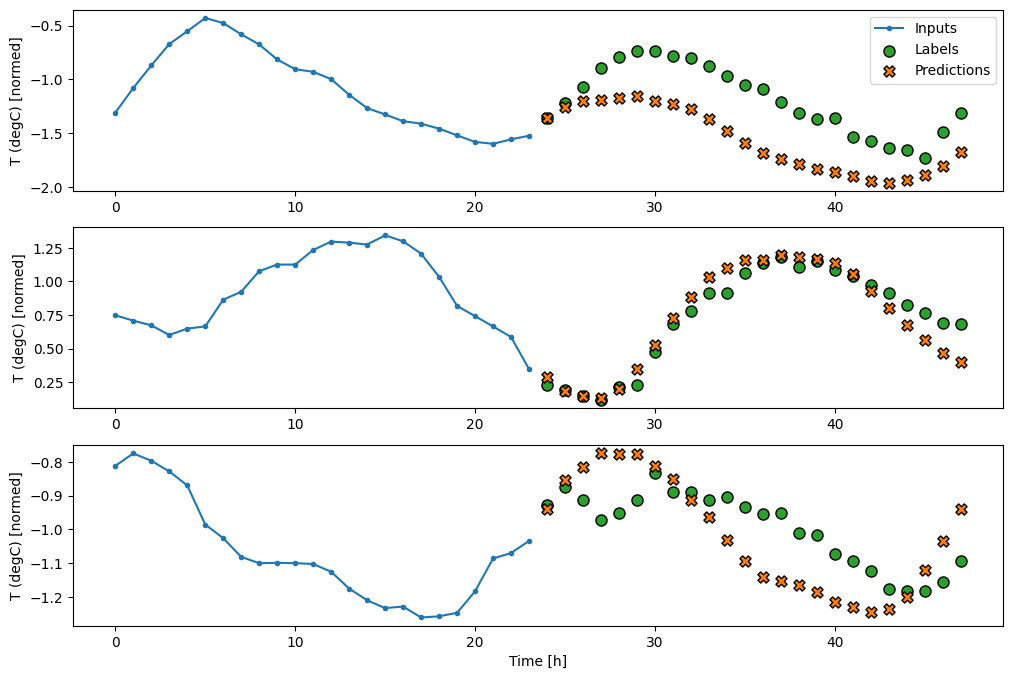

In [88]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

Un modelo convolucional hace predicciones basándose en un historial de ancho fijo, lo que puede conducir a un mejor rendimiento que el modelo denso, ya que puede ver cómo cambian las cosas con el tiempo:

![Un modelo convolucional ve cómo cambian las cosas con el tiempo](images/multistep_conv.png)

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2165 - mean_absolute_error: 0.2821


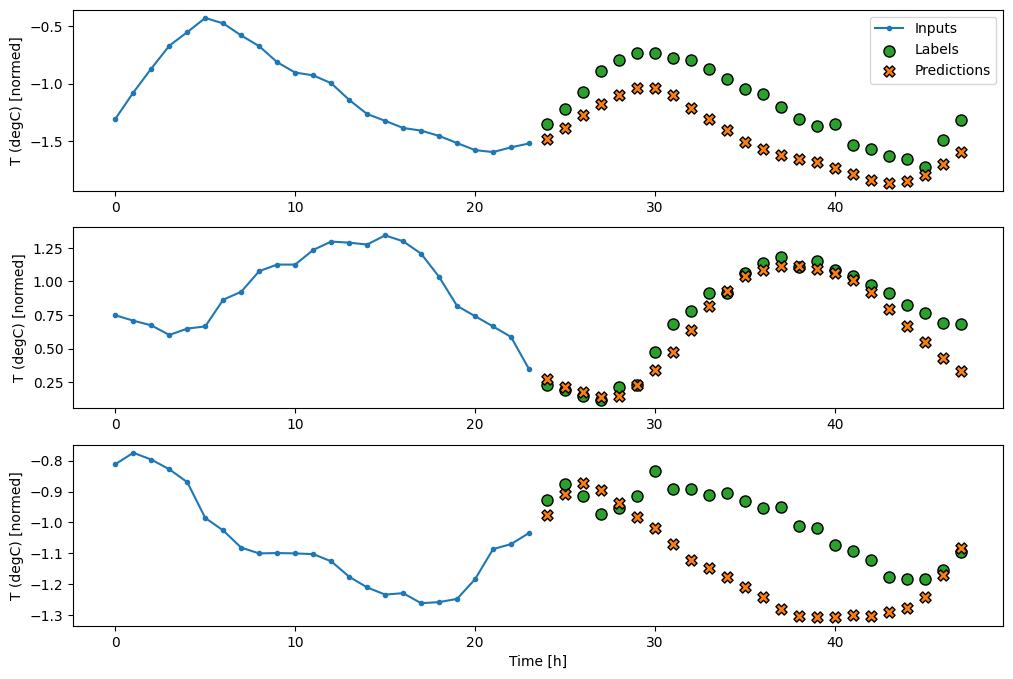

In [90]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

Un modelo recurrente puede aprender a usar un largo historial de entradas, si es relevante para las predicciones que el modelo está haciendo. Aquí el modelo acumulará el estado interno durante 24 horas, antes de hacer una única predicción para las 24 horas siguientes.

En este formato de un solo impulso, el LSTM sólo necesita producir una salida en el último paso de tiempo, así que configure `return_sequences=False` en `tf.keras.layers.LSTM`.

![El LSTM acumula estado a lo largo de la ventana de entrada, y realiza una única predicción para las próximas 24 horas](images/multistep_lstm.png)


437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2130 - mean_absolute_error: 0.2850


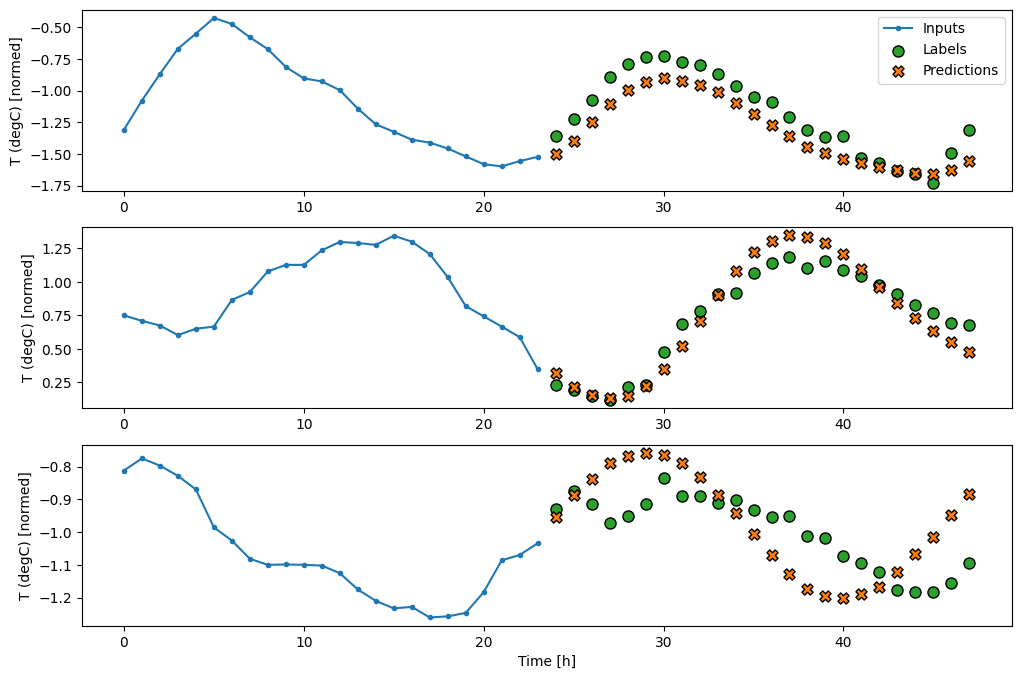

In [91]:
import tensorflow as tf

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Avanzado: Modelo autorregresivo

Todos los modelos anteriores predicen la secuencia de salida completa en un solo paso.

En algunos casos puede ser útil que el modelo desglose esta predicción en pasos de tiempo individuales. Entonces, la salida de cada modelo puede retroalimentarse a sí misma en cada paso y las predicciones pueden hacerse condicionadas por la anterior, como en el clásico <a href="https://arxiv.org/abs/1308.0850" class="external">Generación de secuencias con redes neuronales recurrentes</a>.

Una clara ventaja de este estilo de modelo es que puede configurarse para producir una salida con una longitud variable.

Podría tomar cualquiera de los modelos multisalida de un solo paso entrenados en la primera mitad de este tutorial y ejecutarlo en un bucle de retroalimentación autorregresiva, pero aquí centrará su atención en construir un modelo que haya sido entrenado explícitamente para ello.

![Retroalimentación de la salida de un modelo a su entrada](images/multistep_autoregressive.png)

#### RNN

Este tutorial sólo construye un modelo RNN autorregresivo, pero este patrón podría aplicarse a cualquier modelo diseñado para dar salida a un único paso de tiempo.

El modelo tendrá la misma forma básica que los modelos LSTM de un solo paso que vimos anteriormente: una capa `tf.keras.layers.LSTM` seguida de una capa `tf.keras.layers.Dense` que convierte las salidas de la capa `LSTM` en predicciones del modelo.

Una `tf.keras.layers.LSTM` es una `tf.keras.layers.LSTMCell` envuelta en la `tf.keras.layers.RNN` de nivel superior que administra el estado y secuencia los resultados por usted (Para más detalles, consulte la guía [Redes Neuronales Recurrentes (RNN) con Keras](https://www.tensorflow.org/guide/keras/rnn)).

En este caso, el modelo tiene que administrar manualmente las entradas de cada paso, por lo que usa `tf.keras.layers.LSTMCell` directamente para la interfaz de nivel inferior, de un solo paso de tiempo.

In [92]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [93]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

El primer método que necesita este modelo es un método `warmup` para inicializar su estado interno en función de las entradas. Una vez entrenado, este estado capturará las partes relevantes del historial de entradas. Esto es equivalente al modelo `LSTM` de un solo paso visto anteriormente:

In [94]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

Este método devuelve una predicción de un solo paso de tiempo y el estado interno de la `LSTM`:

In [95]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

Con el estado de la `RNN` y una predicción inicial, puede ahora continuar iterando el modelo retroalimentando las predicciones en cada paso como entrada.

El enfoque más sencillo para recopilar las predicciones de salida es usar una lista Python y un `tf.stack` después del bucle.

Nota: Apilar una lista Python como ésta sólo funciona con eager execution, usando `Model.compile(..., run_eagerly=True)` para el entrenamiento, o con una salida de longitud fija. Para una longitud de salida dinámica, tendría que usar un `tf.TensorArray` en lugar de una lista de Python, y `tf.range` en lugar del `range` de Python.

In [96]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Haga una prueba de este modelo con las entradas del ejemplo:

In [97]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Ahora entrene el modelo:

437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2227 - mean_absolute_error: 0.2979


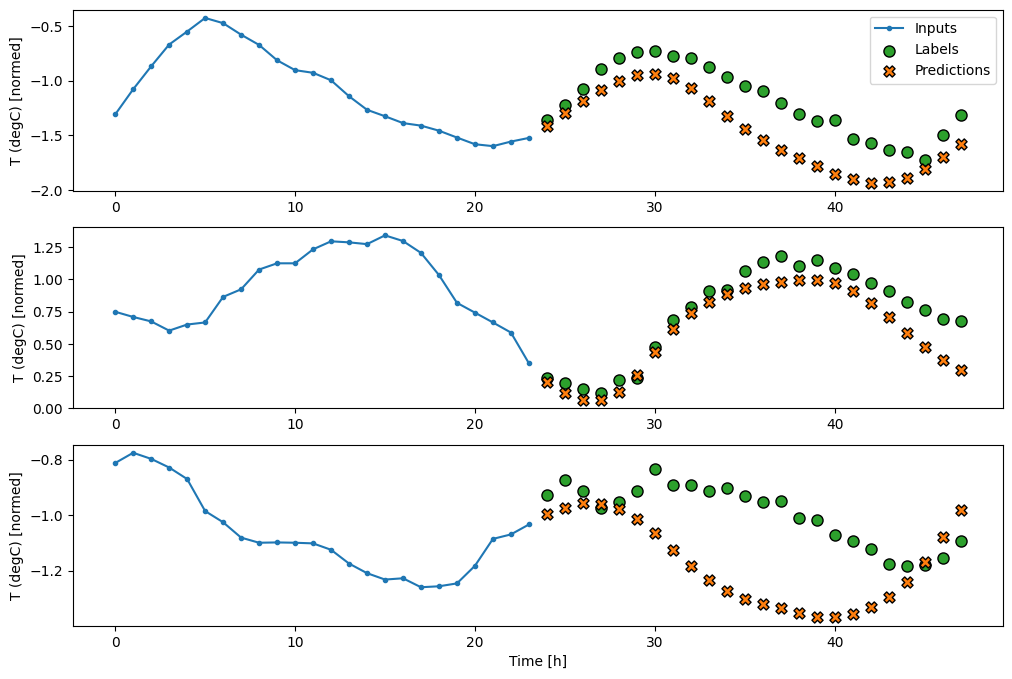

In [98]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Rendimiento

En este problema existen claramente rendimientos decrecientes en función de la complejidad del modelo:

In [100]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

ValueError: 'mean_absolute_error' is not in list

Las métricas de los modelos multisalida de la primera mitad de este tutorial muestran el rendimiento promediado en todas las características de salida. Estos rendimientos son similares pero también están promediados a través de los pasos de tiempo de salida.

In [101]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2978
Dense   : 0.2751
Conv    : 0.2738
LSTM    : 0.2772
AR LSTM : 0.2845


Las ganancias conseguidas al pasar de un modelo denso a modelos convolucionales y recurrentes son sólo de unos pocos puntos porcentuales (si acaso), y el modelo autorregresivo funcionó claramente peor. Así que estos enfoques más complejos pueden no valer la pena en **este** problema, pero no había forma de saberlo sin probar y, además, estos modelos podrían ser útiles para **su** problema.

## Siguientes pasos

Este tutorial fue una rápida introducción a la predicción de series temporales usando TensorFlow.

Para saber más, consulte:

- Capítulo 15 de <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Aprendizaje automático práctico con Scikit-Learn, Keras y TensorFlow</a>, 2ª edición.
- Capítulo 6 de <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Aprendizaje Profundo con Python</a>.
- Lección 8 de <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Introducción de Udacity a TensorFlow para aprendizaje profundo</a>, incluyendo los <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">bloc de notas de ejercicios</a>.

Además, recuerde que puede implementar cualquier <a href="https://otexts.com/fpp2/index.html" class="external">modelo clásico de series temporales</a> en TensorFlow; este tutorial sólo se enfoca en la funcionalidad incorporada de TensorFlow.


##### Copyright 2020 The TensorFlow Authors.

In [102]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using LSTMs, CNNs, GRUs with a larger dataset

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c02_nlp_multiple_models_for_predicting_sentiment.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c02_nlp_multiple_models_for_predicting_sentiment.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this colab, you use different kinds of layers to see how they affect the model.

You will use the glue/sst2 dataset, which is available through tensorflow_datasets.

The General Language Understanding Evaluation (GLUE) benchmark (https://gluebenchmark.com/) is a collection of resources for training, evaluating, and analyzing natural language understanding systems.

These resources include the Stanford Sentiment Treebank (SST) dataset that consists of sentences from movie reviews and human annotations of their sentiment. This colab uses version 2 of the SST dataset.

The splits are:

*   train	67,349
*   validation	872


and the column headings are:

*   sentence
*   label


For more information about the dataset, see [https://www.tensorflow.org/datasets/catalog/glue#gluesst2](https://www.tensorflow.org/datasets/catalog/glue#gluesst2)

In [30]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

# Get the dataset


In [31]:
# Get the dataset.
# It has 70000 items, so might take a while to download
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)


FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence': Text(shape=(), dtype=string),
})
2
['negative', 'positive']


In [32]:
# Get the training and validation datasets
dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<_PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [33]:
# Print some of the entries
for example in dataset_train.take(2):
  review, label = example["sentence"], example["label"]
  print("Review:", review)
  print("Label: %d \n" % label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [34]:
# Get the sentences and the labels
# for both the training and the validation sets
training_reviews = []
training_labels = []

validation_reviews = []
validation_labels = []

# The dataset has 67,000 training entries, but that's a lot to process here!

# If you want to take the entire dataset: WARNING: takes longer!!
# for item in dataset_train.take(-1):

# Take 10,000 reviews
for item in dataset_train.take(10000):
  review, label = item["sentence"], item["label"]
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

print ("\nNumber of training reviews is: ", len(training_reviews))

# print some of the reviews and labels
for i in range(0, 2):
  print (training_reviews[i])
  print (training_labels[i])

# Get the validation data
# there's only about 800 items, so take them all
for item in dataset_validation.take(-1):
  review, label = item["sentence"], item["label"]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))

# Print some of the validation reviews and labels
for i in range(0, 2):
  print (validation_reviews[i])
  print (validation_labels[i])



Number of training reviews is:  10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


# Tokenize the words and sequence the sentences


In [35]:
# There's a total of 21224 words in the reviews
# but many of them are irrelevant like with, it, of, on.
# If we take a subset of the training data, then the vocab
# will be smaller.

# A reasonable review might have about 50 words or so,
# so we can set max_length to 50 (but feel free to change it as you like)

vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index


# Pad the sequences

In [37]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length,
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

# Create the model using an Embedding

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [28]:
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5534 - loss: 0.6858 - val_accuracy: 0.5264 - val_loss: 0.6897
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5693 - loss: 0.6786 - val_accuracy: 0.5791 - val_loss: 0.6794
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6009 - loss: 0.6686 - val_accuracy: 0.6078 - val_loss: 0.6632
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6272 - loss: 0.6452 - val_accuracy: 0.6583 - val_loss: 0.6364
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6741 - loss: 0.6203 - val_accuracy: 0.6972 - val_loss: 0.6047
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7130 - loss: 0.5887 - val_accuracy: 0.7339 - val_loss: 0.5743
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7403 - loss: 0.5588 - val_accuracy: 0.7431 - val_loss: 0.5498
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7588 - loss: 0.5283 - val_accuracy: 0.

# Plot the accurracy and loss

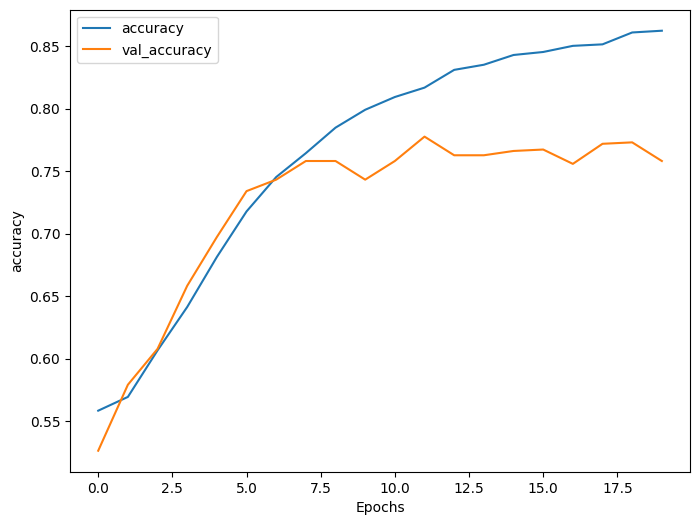

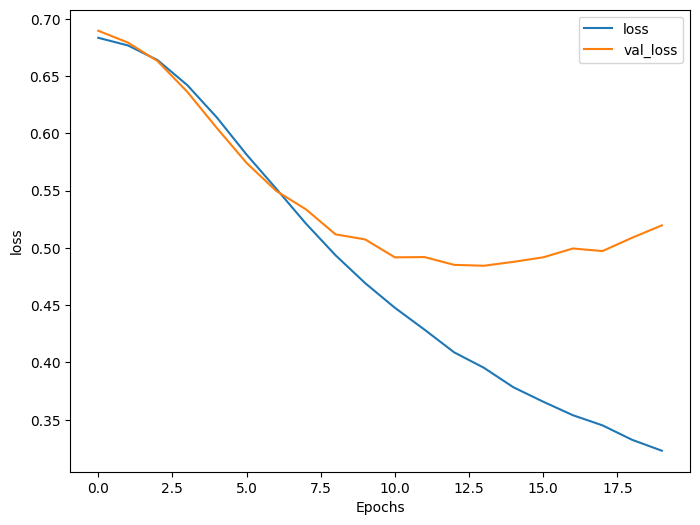

In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Write a function to predict the sentiment of reviews

In [39]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]


In [40]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type,
                                 maxlen=max_length)
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
I loved this movie
[0.5203281]


that was the worst movie I've ever seen
[0.5193822]


too much violence even for a Bond film
[0.5187442]


a captivating recounting of a cherished myth
[0.51991254]




# Define a function to train and show the results of models with different layers

In [41]:
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

# Use a CNN

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5588 - loss: 0.6887 - val_accuracy: 0.5092 - val_loss: 0.6941
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5562 - loss: 0.6836 - val_accuracy: 0.5092 - val_loss: 0.6938
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5652 - loss: 0.6785 - val_accuracy: 0.5092 - val_loss: 0.6914
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5641 - loss: 0.6750 - val_accuracy: 0.5241 - val_loss: 0.6880
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5752 - loss: 0.6695 - val_accuracy: 0.5688 - val_loss: 0.6831
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5919 - loss: 0.6611 - val_accuracy: 0.5986 - val_loss: 0.6755
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6314 - loss: 0.6499 - val_accuracy: 0.6686 - val_loss: 0.6648
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6814 - loss: 0.6318 - val_accuracy: 0.

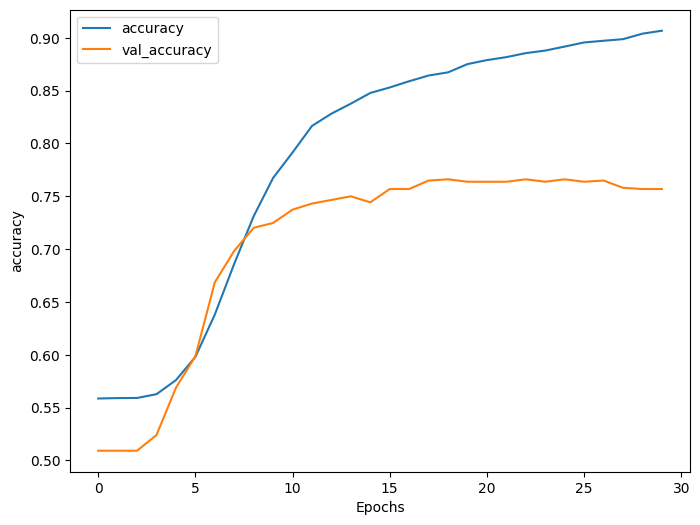

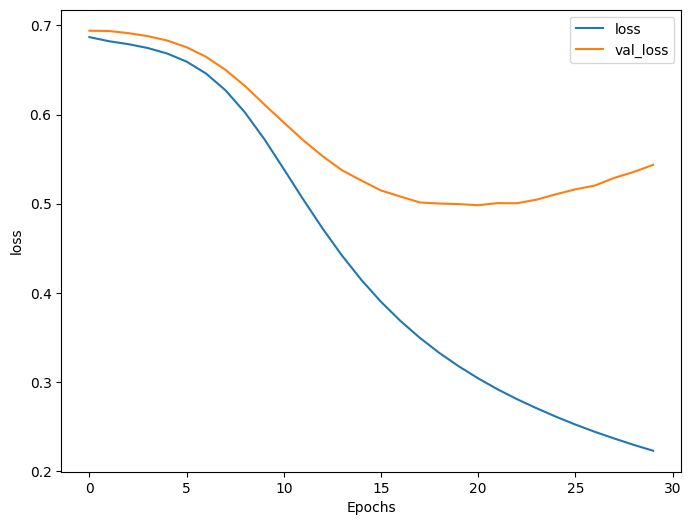

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
I loved this movie
[0.8740703]


that was the worst movie I've ever seen
[0.05899359]


too much violence even for a Bond film
[0.02065038]


a captivating recounting of a cherished myth
[0.70666283]




In [42]:
num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

# Use a GRU

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5309 - loss: 0.6922 - val_accuracy: 0.5092 - val_loss: 0.6930
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5621 - loss: 0.6874 - val_accuracy: 0.5092 - val_loss: 0.6940
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5628 - loss: 0.6848 - val_accuracy: 0.5092 - val_loss: 0.6952
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5563 - loss: 0.6846 - val_accuracy: 0.5092 - val_loss: 0.6964
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5614 - loss: 0.6818 - val_accuracy: 0.5092 - val_loss: 0.6978
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5599 - loss: 0.6800 - val_accuracy: 0.5092 - val_loss: 0.7007
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5608 - loss: 0.6764 - val_accuracy: 0.5092 - val_loss: 0.7061
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5537 - loss: 0.6702 - val_accuracy: 0

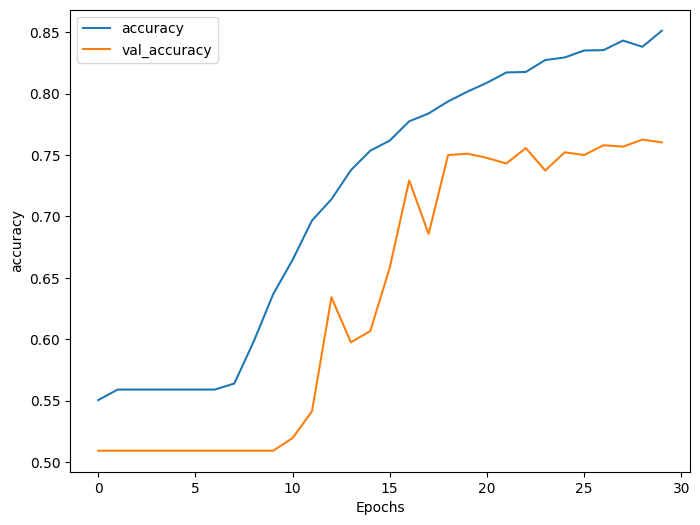

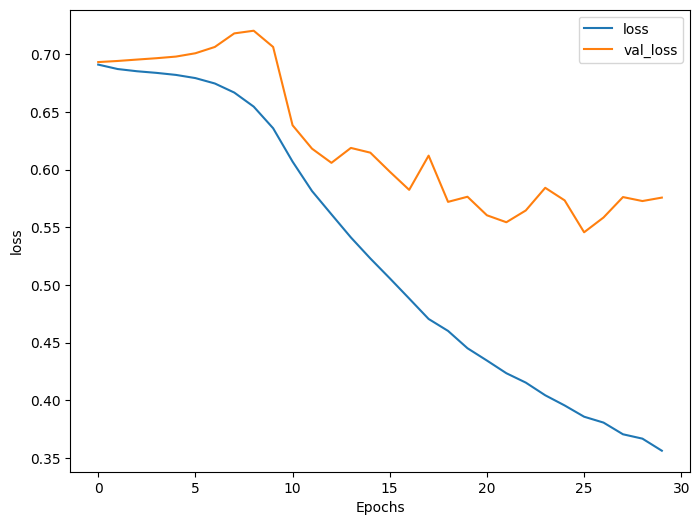

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
I loved this movie
[0.34343228]


that was the worst movie I've ever seen
[0.13230191]


too much violence even for a Bond film
[0.063413]


a captivating recounting of a cherished myth
[0.42605132]




In [43]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

# Add a bidirectional LSTM

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5241 - loss: 0.6918 - val_accuracy: 0.5092 - val_loss: 0.6942
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5567 - loss: 0.6863 - val_accuracy: 0.5092 - val_loss: 0.6976
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5635 - loss: 0.6829 - val_accuracy: 0.5092 - val_loss: 0.7009
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5514 - loss: 0.6843 - val_accuracy: 0.5092 - val_loss: 0.7045
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5631 - loss: 0.6797 - val_accuracy: 0.5092 - val_loss: 0.7066
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5602 - loss: 0.6773 - val_accuracy: 0.5092 - val_loss: 0.7117
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5639 - loss: 0.6754 - val_accuracy: 0.5092 - val_loss: 0.7174
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5633 - loss: 0.6720 - val_accuracy:

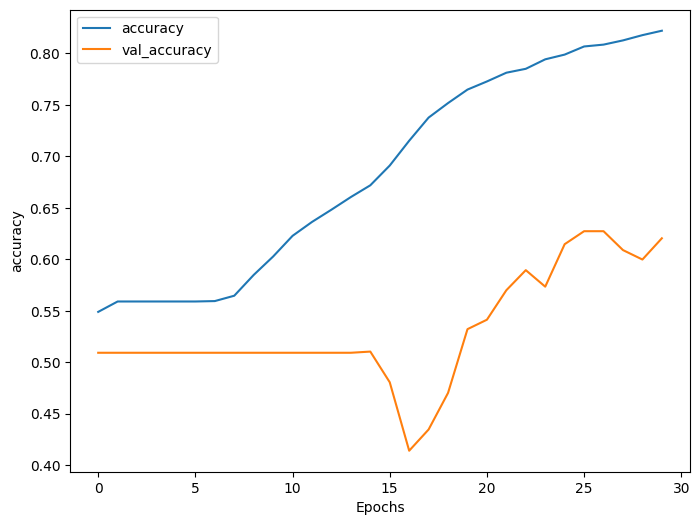

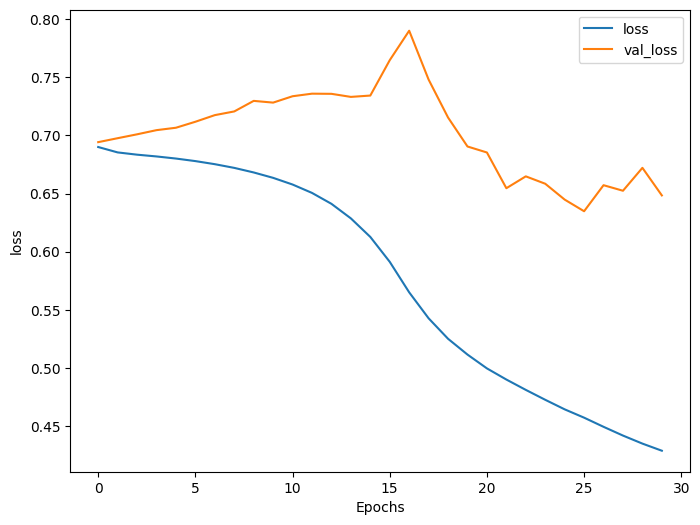

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
I loved this movie
[0.4659656]


that was the worst movie I've ever seen
[0.28153345]


too much violence even for a Bond film
[0.42163733]


a captivating recounting of a cherished myth
[0.47870576]




In [45]:
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

# Use multiple bidirectional LSTMs

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5483 - loss: 0.6872 - val_accuracy: 0.5092 - val_loss: 0.7139
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6804 - loss: 0.6000 - val_accuracy: 0.5092 - val_loss: 0.9813
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8264 - loss: 0.3881 - val_accuracy: 0.5183 - val_loss: 0.7219
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8554 - loss: 0.3218 - val_accuracy: 0.5126 - val_loss: 0.8180
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8719 - loss: 0.3036 - val_accuracy: 0.5115 - val_loss: 1.0330
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8858 - loss: 0.2539 - val_accuracy: 0.5195 - val_loss: 0.7403
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8957 - loss: 0.2466 - val_accuracy: 0.5115 - val_loss: 1.5003
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8948 - loss: 0.2326 - val_accu

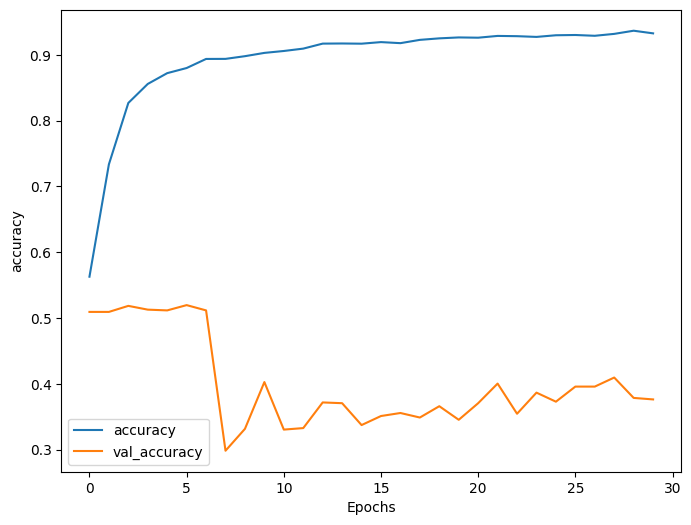

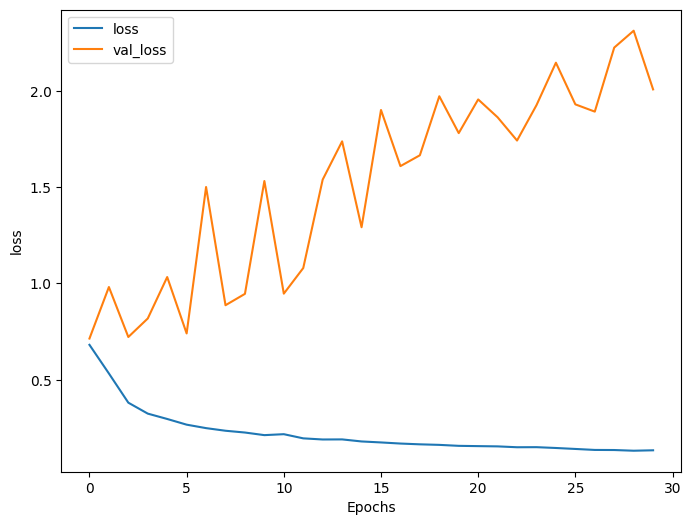

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
I loved this movie
[0.992438]


that was the worst movie I've ever seen
[0.8792997]


too much violence even for a Bond film
[0.00889686]


a captivating recounting of a cherished myth
[0.99634534]




In [44]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

# Try some more reviews

In [46]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time.
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director
 who made my most favorite movie ever, I was very disappointed in the tedious
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7,
               review8, review9, review10]


In [47]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
I loved this movie
[0.5203281]


that was the worst movie I've ever seen
[0.5193822]


too much violence even for a Bond film
[0.5187442]


a captivating recounting of a cherished myth
[0.51991254]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.50449353]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.51421666]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.51265293]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.51151794]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedi

In [48]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
I loved this movie
[0.8740703]


that was the worst movie I've ever seen
[0.05899359]


too much violence even for a Bond film
[0.02065038]


a captivating recounting of a cherished myth
[0.70666283]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.786489]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.9455846]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.7831938]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.72598845]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 stor

In [49]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With bidirectional GRU
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
I loved this movie
[0.34343228]


that was the worst movie I've ever seen
[0.13230191]


too much violence even for a Bond film
[0.063413]


a captivating recounting of a cherished myth
[0.42605132]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.18828532]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.18748413]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.18106437]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.23832639]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in t

In [50]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
I loved this movie
[0.4659656]


that was the worst movie I've ever seen
[0.28153345]


too much violence even for a Bond film
[0.42163733]


a captivating recounting of a cherished myth
[0.47870576]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.6144645]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.31986657]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.19445075]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.35577]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappoin

In [51]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
I loved this movie
[0.992438]


that was the worst movie I've ever seen
[0.8792997]


too much violence even for a Bond film
[0.00889686]


a captivating recounting of a cherished myth
[0.99634534]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.96948403]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.9973369]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.99481755]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.9981645]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappoin

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using LSTMs with the subwords dataset


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c01_nlp_lstms_with_reviews_subwords_dataset.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c01_nlp_lstms_with_reviews_subwords_dataset.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this colab, you'll compare the results of using a model with an Embedding layer and then adding bidirectional LSTM layers.

You'll work with the dataset of subwords for the combined Yelp and Amazon reviews.

You'll use your models to predict the sentiment of new reviews.

In [52]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get the dataset

Start by getting the dataset containing Amazon and Yelp reviews, with their related sentiment (1 for positive, 0 for negative). This dataset was originally extracted from [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set).


In [53]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2025-04-21 00:01:25--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 142.250.101.113, 142.250.101.100, 142.250.101.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2025-04-21 00:01:25--  https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127831 (125K) [application/octet-stream]
Saving to: ‘/tmp/sentiment.csv’

/tmp/sentiment.csv  100%[===================>] 124.83K  --.-KB/s    in 0.04s   

2025-04-21 00:01:27 (3.07 

In [54]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

# Extract out sentences and labels
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [55]:
# Print some example sentences and labels
for x in range(2):
  print(sentences[x])
  print(labels[x])
  print("\n")

So there is no way for me to plug it in here in the US unless I go by a converter.
0


Good case Excellent value.
1




#Create a subwords dataset

We will use the Amazon and Yelp reviews dataset with tensorflow_datasets's SubwordTextEncoder functionality.

SubwordTextEncoder.build_from_corpus() will create a tokenizer for us. You could also use this functionality to get subwords from a much larger corpus of text as well, but we'll just use our existing dataset here.

We'll create a subword vocab_size of only the 1,000 most common subwords, as well as cutting off each subword to be at most 5 characters.

Check out the related documentation for the the subword text encoder [here](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder#build_from_corpus).

In [56]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

# How big is the vocab size?
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  999


In [57]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [58]:
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


## Replace sentence data with encoded subwords

Now, we'll create the sequences to be used for training by actually encoding each of the individual sentences. This is equivalent to `text_to_sequences` with the `Tokenizer` we used in earlier exercises.

In [59]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [60]:
# Check the sentences are appropriately replaced
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


## Final pre-processing

Before training, we still need to pad the sequences, as well as split into training and test sets.

In [61]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sequences
sequences_padded = pad_sequences(sentences, maxlen=max_length,
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Create the model using an Embedding

In [62]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [63]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5172 - loss: 0.6923 - val_accuracy: 0.4185 - val_loss: 0.7027
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5513 - loss: 0.6872 - val_accuracy: 0.4536 - val_loss: 0.7032
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5574 - loss: 0.6846 - val_accuracy: 0.4862 - val_loss: 0.6946
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.6767 - val_accuracy: 0.6692 - val_loss: 0.6756
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6516 - loss: 0.6716 - val_accuracy: 0.7118 - val_loss: 0.6691
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7080 - loss: 0.6609 - val_accuracy: 0.5013 - val_loss: 0.6884
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6611 - loss: 0.6395 - val_accuracy: 0.7218 - val_loss: 0.6420
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7594 - loss: 0.6129 - val_accuracy: 0.6541 - val_loss

# Plot the accuracy and loss

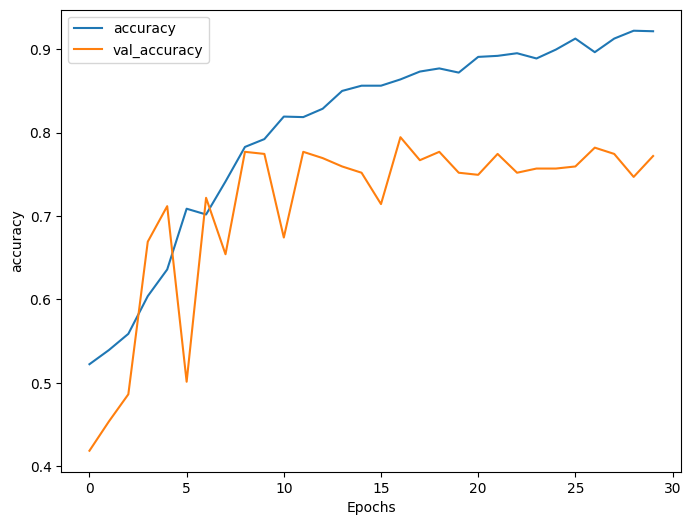

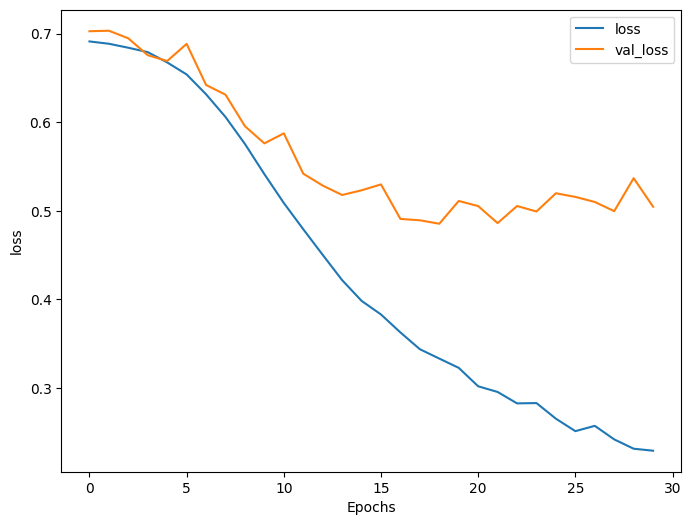

In [64]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Define a function to predict the sentiment of reviews

We'll be creating models with some differences and will use each model to predict the sentiment of some new reviews.

To save time, create a function that will take in a model and some new reviews, and print out the sentiment of each reviews.

The higher the sentiment value is to 1, the more positive the review is.

In [65]:
# Define a function to take a series of reviews
# and predict whether each one is a positive or negative review

# max_length = 100 # previously defined

def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post'
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length,
                                 padding=padding_type, truncating=trunc_type)

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):

    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [66]:
# Use the model to predict some reviews
fake_reviews = ["I love this phone",
                "Everything was cold",
                "Everything was hot exactly as I wanted",
                "Everything was green",
                "the host seated us immediately",
                "they gave us free chocolate cake",
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model, fake_reviews)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.7480669]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.11729757]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.19853505]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.

# Define a function to train and show the results of models with different layers

In the rest of this colab, we will define models, and then see the results.

Define a function that will take the model, compile it, train it, graph the accuracy and loss, and then predict some results.

In [67]:
def fit_model_now (model, sentences) :
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs=num_epochs,
                      validation_data=(testing_sequences, testing_labels_final))
  return history

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def fit_model_and_show_results (model, sentences):
  history = fit_model_now(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

# Add a bidirectional LSTM

Create a new model that uses a bidirectional LSTM.

Then use the function we have already defined to compile the model, train it, graph the accuracy and loss, then predict some results.

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4900 - loss: 0.6932 - val_accuracy: 0.4110 - val_loss: 0.6942
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5442 - loss: 0.6923 - val_accuracy: 0.7168 - val_loss: 0.6866
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7412 - loss: 0.6674 - val_accuracy: 0.7393 - val_loss: 0.5915
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8027 - loss: 0.5091 - val_accuracy: 0.7444 - val_loss: 0.5269
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8596 - loss: 0.3679 - val_accuracy: 0.7644 - val_loss: 0.5283
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9030 - loss: 0.2560 - val_accuracy: 0.7669 - val_loss: 0.5411
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9291 - loss: 0.2192 - val_accuracy: 0.7619 - val_loss: 0.5836
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9438 - loss: 0.1791 - val_accuracy: 0.7343 - v

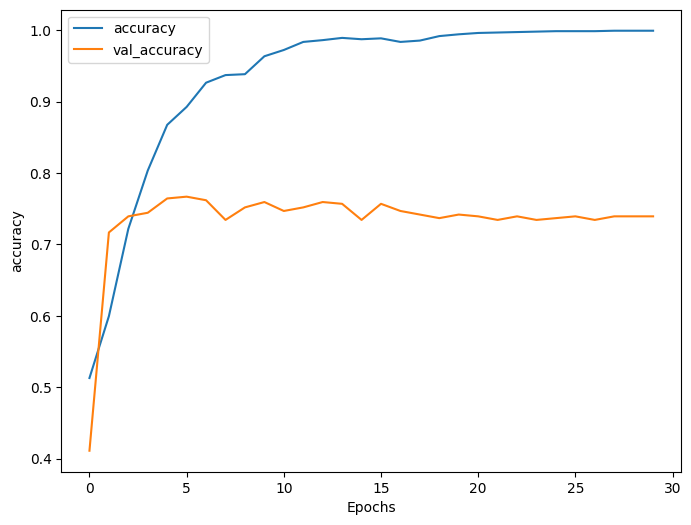

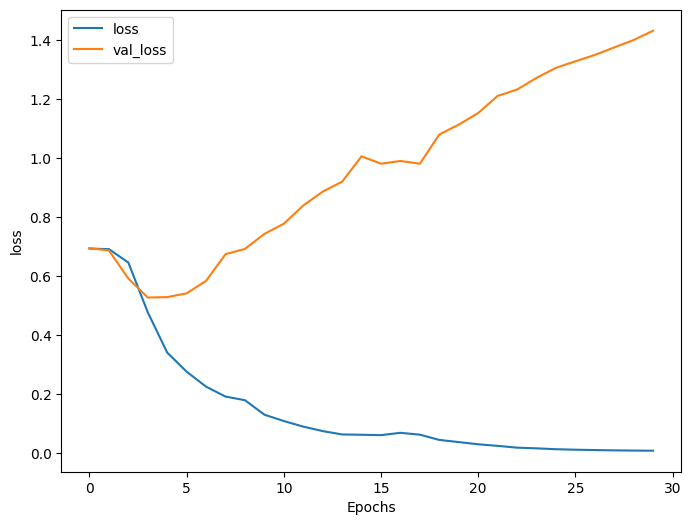

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9998294]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.01907711]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.9997193]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.0

In [68]:
# Define the model
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, fake_reviews)


# Use multiple bidirectional layers

Now let's see if we get any improvements from adding another Bidirectional LSTM layer to the model.

Notice that the first Bidirectionl LSTM layer returns a sequence.

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5230 - loss: 0.6924 - val_accuracy: 0.4110 - val_loss: 0.6994
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5866 - loss: 0.6638 - val_accuracy: 0.6692 - val_loss: 0.6409
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8414 - loss: 0.4191 - val_accuracy: 0.7644 - val_loss: 0.5130
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8831 - loss: 0.3138 - val_accuracy: 0.7544 - val_loss: 0.5352
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9268 - loss: 0.2255 - val_accuracy: 0.7644 - val_loss: 0.6393
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9426 - loss: 0.1914 - val_accuracy: 0.7368 - val_loss: 0.6795
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9461 - loss: 0.1773 - val_accuracy: 0.7494 - val_loss: 0.7136
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9653 - loss: 0.1302 - val_accuracy: 0.7544 - v

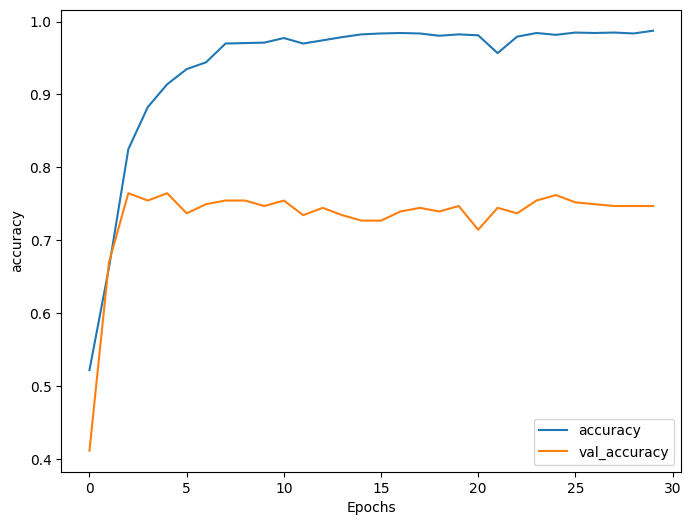

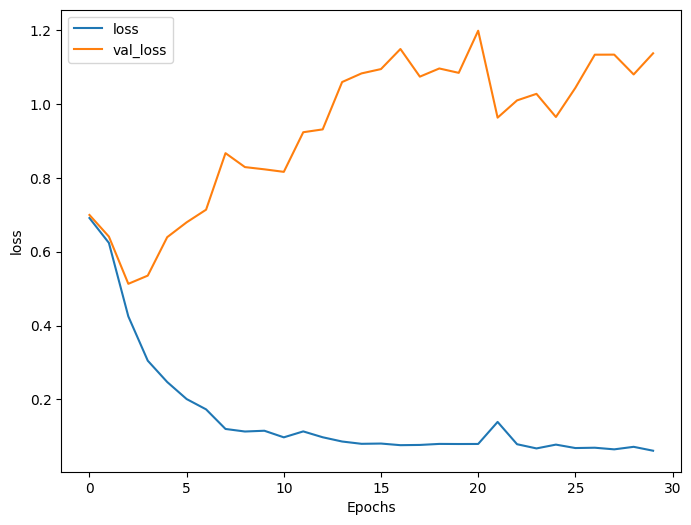

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99825066]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.9144515]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.9892575]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.0

In [69]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)

# Compare predictions for all the models

It can be hard to see which model gives a better prediction for different reviews when you examine each model separately. So for comparison purposes, here we define some more reviews and print out the predictions that each of the three models gives for each review:

*   Embeddings and a Global Average Pooling layer
*   Embeddings and a Bidirectional LSTM layer
*   Embeddings and two Bidirectional LSTM layers

The results are not always what you might expect. The input dataset is fairly small, it has less than 2000 reviews. Some of the reviews are fairly short, and some of the short ones are fairly repetitive which reduces their impact on improving the  model, such as these two reviews:

*   Bad Quality.
*   Low Quality.

Feel free to add more reviews of your own, or change the reviews. The results will depend on the combination of words in the reviews, and how well they match to reviews in the training set.

How do the different models handle things like "wasn't good" which contains a positive word (good) but is a poor review?


In [70]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [71]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Embeddings only:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
lovely
[0.7414149]


dreadful
[0.26841405]


stay away
[0.47667962]


everything was hot exactly as I wanted
[0.49005508]


everything was not exactly as I wanted
[0.24969086]


they gave us free chocolate cake
[0.5471369]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.0346897]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.30882213]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.72555083]


that place does not have quality meals and it isn't a good place to go for dinner
[0.6654273]




In [72]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
lovely
[0.99973375]


dreadful
[0.12686464]


stay away
[0.9910768]


everything was hot exactly as I wanted
[0.99960804]


everything was not exactly as I wanted
[0.99499124]


they gave us free chocolate cake
[0.9872288]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.00091556]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.999666]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.9994586]


that place does not have quality meals and it isn't a good place to go for dinner
[0.9701375]




In [73]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 With two bidirectional LSTMs:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
lovely
[0.9981363]


dreadful
[0.03580922]


stay away
[0.02623677]


everything was hot exactly as I wanted
[0.99737716]


everything was not exactly as I wanted
[0.02974395]


they gave us free chocolate cake
[0.9952801]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.01760268]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.02462936]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.18491046]


that place does not have quality meals and it isn't a good place to go for dinner
[0.01956611]


